<a href="https://colab.research.google.com/github/gmaymon3/machine_learning_robot_heating/blob/main/AME_508_Final_Project_Multi_Model_Rev3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predictive Modeling of Heat Dissipation Using Neural Networks**
AME 508 Final Project

Due: December 8, 2023

Members: Gabriel Maymon, Meghana Sagare, Shantanu Thorat, Marlene Escobedo


# **Loading Data**

In [ ]:
import numpy as np
import torch
from google.colab import drive
import torch.nn.functional as F
from sklearn import preprocessing
import random

scalar = preprocessing.MinMaxScaler()


############################## LOAD DATA FROM GOOGLE DRIVE #####################
drive.mount('/content/drive')

# Import Final_Temp_Arrays.npy
#path1 = '/content/drive/Shared drives/AME508 Data/All Data Old 10_28/Final_Temp_Arrays_All.npy'
path1 = '/content/drive/Shared drives/AME508 Data/Final_Temp_Arrays_All.npy'
Final_Temp_Arrays = np.load(path1)
print(f'Final Temp Array Shape: {np.shape(Final_Temp_Arrays)}')

# Import Initial_Temp_Arrays.npy
#path2 = '/content/drive/Shared drives/AME508 Data/All Data Old 10_28/Initial_Temp_Arrays_All.npy'
path2 = '/content/drive/Shared drives/AME508 Data/Initial_Temp_Arrays_All.npy'
Initial_Temp_Arrays = np.load(path2)
print(f'Initial Temp Array Shape: {np.shape(Initial_Temp_Arrays)}')

# Import Initial_Temp_Arrays.npy
#path3 = '/content/drive/Shared drives/AME508 Data/All Data Old 10_28/Position_Arrays_All.npy'
path3 = '/content/drive/Shared drives/AME508 Data/Position_Arrays_All.npy'
Position_Arrays = np.load(path3)
print(f'Position Array Shape: {np.shape(Position_Arrays)}')

############################# EXTRACT 500 RANDOM POINTS FOR TEST AND 500 FOR VALIDATION #####################

# Section out training and testing samples
random.seed(1)
random_ind_indices = random.sample(range(Initial_Temp_Arrays.shape[0]), 1000)
random_ind_indices_validation = random_ind_indices[:500]
random_ind_indices_test = random_ind_indices[500:]

# Initial Temp Arrays
Test_Initial_Temp_Arrays = Initial_Temp_Arrays[random_ind_indices_test, :]
Val_Initial_Temp_Arrays = Initial_Temp_Arrays[random_ind_indices_validation, :]
Train_Initial_Temp_Arrays = np.delete(Initial_Temp_Arrays, random_ind_indices, axis=0)

# Final Temp Arrays
Test_Final_Temp_Arrays = Final_Temp_Arrays[random_ind_indices_test, :]
Val_Final_Temp_Arrays = Final_Temp_Arrays[random_ind_indices_validation, :]
Train_Final_Temp_Arrays = np.delete(Final_Temp_Arrays, random_ind_indices, axis=0)

# Position Arrays
Test_Position_Arrays = Position_Arrays[random_ind_indices_test, :]
Val_Position_Arrays = Position_Arrays[random_ind_indices_validation, :]
Train_Position_Arrays = np.delete(Position_Arrays, random_ind_indices, axis=0)

print(random_ind_indices_validation)
print(random_ind_indices_test)
print(Test_Initial_Temp_Arrays.shape)
print(Train_Initial_Temp_Arrays.shape)

################################################################################
############################## TRAIN DATA #########################################
############################## CONVERT DATA TO PYTORCH TENSORS #####################
# SIZE (N,25)
initial_temp_torch = torch.tensor(Train_Initial_Temp_Arrays,dtype=torch.float32)
initial_temp_reshape = torch.reshape(initial_temp_torch, (np.shape(Train_Initial_Temp_Arrays)[0], 25))
print(np.shape(initial_temp_reshape))

# SIZE (N,2)
position_torch = torch.tensor(Train_Position_Arrays,dtype=torch.float32)
position_reshape = torch.reshape(position_torch, (np.shape(Train_Position_Arrays)[0], 2))
print(np.shape(position_reshape))

# SIZE (N,25)
final_temp_torch = torch.tensor(Train_Final_Temp_Arrays,dtype=torch.float32)
final_temp_reshape = torch.reshape(final_temp_torch, (np.shape(Train_Final_Temp_Arrays)[0], 25))
print(np.shape(final_temp_reshape))

############################## REFORMAT HEATED NODE POS TO 1D #####################
### Train Branch Input ###
print('The Size of the Branch Input (All Data) is: ')
position_one = position_reshape[:,0]+(position_reshape[:,1]-1)*5 - 1
position_one = position_one.view(-1,1)
one_train_branch_input_data = torch.cat((initial_temp_reshape,position_one),dim=1)
train_branch_input_data = one_train_branch_input_data.repeat(25,1)
print(train_branch_input_data.shape)

### Train Trunk Input ####
# Create a tensor with the specified pattern
tensor_pattern = torch.cat([torch.full((np.shape(Train_Final_Temp_Arrays)[0],), i) for i in range(25)])

# Reshape the tensor to have a shape of (25, 25)
reshaped_tensor = tensor_pattern.reshape(25, -1)
train_trunk_input_data = reshaped_tensor.view(-1,1)
train_trunk_input_data = train_trunk_input_data.to(torch.float32)

print('The Size of the Trunk Input (All Data) is: ')
print(train_trunk_input_data.shape)

### Train Output Data ####
train_output_data = torch.tensor([])
for i in range(25):
  col = final_temp_reshape[:,i]
  train_output_data = torch.cat((train_output_data, col))

train_output_data = train_output_data.view(-1,1)
print('The Size of the Output (All Data) is: ')
print(train_output_data.shape)

######################### CREATE DICTIONARIES FROM DATA FOR EACH HEATED NODE #####################
train_branch_input_dict = {}
train_trunk_input_dict = {}
train_output_dict = {}

#### Extract Data for a single node and put into dictionary value ####
for n in range(25):
  node_of_interest = n
  single_node_heat_train_branch_input = torch.tensor([]) # Initialize empty tensors
  single_node_heat_train_trunk_input = torch.tensor([])
  single_node_heat_train_output = torch.tensor([])
  for k,data_set in enumerate(train_branch_input_data):
    if data_set[25] == node_of_interest:
      # Append data to tensor if is the heated node of interest
      single_node_heat_train_branch_input = torch.cat([single_node_heat_train_branch_input, data_set.unsqueeze(0)], dim=0)
      single_node_heat_train_trunk_input = torch.cat([single_node_heat_train_trunk_input, train_trunk_input_data[k].unsqueeze(0)], dim=0)
      single_node_heat_train_output = torch.cat([single_node_heat_train_output, train_output_data[k].unsqueeze(0)], dim=0)

  # Get rid of the heated node. We don't need it now that we have a dictionary withe key corresponding to the heated node
  single_node_heat_train_branch_input = single_node_heat_train_branch_input[:, :-1]
  print()
  print('Input Size for Data for node ' +str(n))
  print('The Size of the Branch Input (One Heated Node Data) is: ')
  print(single_node_heat_train_branch_input.shape)
  print('The Size of the Trunk Input (One Heated Node Data) is: ')
  print(single_node_heat_train_trunk_input.shape)
  print('The Size of the Ouput (One Heated Node Data) is: ')
  print(single_node_heat_train_output.shape)
  num_data_points = single_node_heat_train_branch_input.shape[0]/25

  # Calculate the new length (nearest multiple of 100)
  new_length = (single_node_heat_train_branch_input.shape[0] // 100) * 100

  # Shorten the tensor to the nearest multiple of 100
  single_node_heat_train_branch_input = single_node_heat_train_branch_input[:new_length]
  single_node_heat_train_trunk_input = single_node_heat_train_trunk_input[:new_length]
  single_node_heat_train_output = single_node_heat_train_output[:new_length]

  # Put each node output into a dictionary
  train_branch_input_dict[node_of_interest] = single_node_heat_train_branch_input
  train_trunk_input_dict[node_of_interest] = single_node_heat_train_trunk_input
  train_output_dict[node_of_interest] = single_node_heat_train_output

  print("The shortened data set is (Helps w/ Batching): ")
  print(single_node_heat_train_branch_input.shape)
  print(single_node_heat_train_trunk_input.shape)
  print(single_node_heat_train_output.shape)


################################################################################
############################## TEST DATA #########################################
############################## CONVERT DATA TO PYTORCH TENSORS #####################
# SIZE (N,25)
test_initial_temp_torch = torch.tensor(Test_Initial_Temp_Arrays,dtype=torch.float32)
test_initial_temp_reshape = torch.reshape(test_initial_temp_torch, (np.shape(Test_Initial_Temp_Arrays)[0], 25))
print(np.shape(test_initial_temp_reshape))

# SIZE (N,2)
test_position_torch = torch.tensor(Test_Position_Arrays,dtype=torch.float32)
test_position_reshape = torch.reshape(test_position_torch, (np.shape(Test_Position_Arrays)[0], 2))
print(np.shape(test_position_reshape))

# SIZE (N,25)
test_final_temp_torch = torch.tensor(Test_Final_Temp_Arrays,dtype=torch.float32)
test_final_temp_reshape = torch.reshape(test_final_temp_torch, (np.shape(Test_Final_Temp_Arrays)[0], 25))
print(np.shape(test_final_temp_reshape))

############################## REFORMAT HEATED NODE POS TO 1D #####################
### Train Branch Input ###
print('The Size of the Branch Input (All Data) is: ')
test_position_one = test_position_reshape[:,0]+(test_position_reshape[:,1]-1)*5 - 1
test_position_one = test_position_one.view(-1,1)
test_one_branch_input_data = torch.cat((test_initial_temp_reshape,test_position_one),dim=1)
test_branch_input_data = test_one_branch_input_data.repeat(25,1)
print(test_branch_input_data.shape)

### Train Trunk Input ####
# Create a tensor with the specified pattern
test_tensor_pattern = torch.cat([torch.full((np.shape(Test_Final_Temp_Arrays)[0],), i) for i in range(25)])

# Reshape the tensor to have a shape of (25, 25)
test_reshaped_tensor = test_tensor_pattern.reshape(25, -1)
test_trunk_input_data = test_reshaped_tensor.view(-1,1)
test_trunk_input_data = test_trunk_input_data.to(torch.float32)

print('The Size of the Trunk Input (All Data) is: ')
print(test_trunk_input_data.shape)

### Train Output Data ####
test_output_data = torch.tensor([])
for i in range(25):
  col = test_final_temp_reshape[:,i]
  test_output_data = torch.cat((test_output_data, col))

test_output_data = test_output_data.view(-1,1)
print('The Size of the Output (All Data) is: ')
print(test_output_data.shape)

######################### CREATE DICTIONARIES FROM DATA FOR EACH HEATED NODE #####################
test_branch_input_dict = {}
test_trunk_input_dict = {}
test_output_dict = {}

#### Extract Data for a single node and put into dictionary value ####
for n in range(25):
  node_of_interest = n
  single_node_heat_test_branch_input = torch.tensor([]) # Initialize empty tensors
  single_node_heat_test_trunk_input = torch.tensor([])
  single_node_heat_test_output = torch.tensor([])
  for k,data_set in enumerate(test_branch_input_data):
    if data_set[25] == node_of_interest:
      # Append data to tensor if is the heated node of interest
      single_node_heat_test_branch_input = torch.cat([single_node_heat_test_branch_input, data_set.unsqueeze(0)], dim=0)
      single_node_heat_test_trunk_input = torch.cat([single_node_heat_test_trunk_input, test_trunk_input_data[k].unsqueeze(0)], dim=0)
      single_node_heat_test_output = torch.cat([single_node_heat_test_output, test_output_data[k].unsqueeze(0)], dim=0)

  # Get rid of the heated node. We don't need it now that we have a dictionary withe key corresponding to the heated node
  single_node_heat_test_branch_input = single_node_heat_test_branch_input[:, :-1]
  print()
  print('Input Size for Data for node ' +str(n))
  print('The Size of the Branch Input (One Heated Node Data) is: ')
  print(single_node_heat_test_branch_input.shape)
  print('The Size of the Trunk Input (One Heated Node Data) is: ')
  print(single_node_heat_test_trunk_input.shape)
  print('The Size of the Ouput (One Heated Node Data) is: ')
  print(single_node_heat_test_output.shape)
  num_data_points = single_node_heat_test_branch_input.shape[0]/25

  # Calculate the new length (nearest multiple of 100)
  new_length = (single_node_heat_test_branch_input.shape[0] // 100) * 100

  # Shorten the tensor to the nearest multiple of 100
  single_node_heat_test_branch_input = single_node_heat_test_branch_input[:new_length]
  single_node_heat_test_trunk_input = single_node_heat_test_trunk_input[:new_length]
  single_node_heat_test_output = single_node_heat_test_output[:new_length]

  # Put each node output into a dictionary
  test_branch_input_dict[node_of_interest] = single_node_heat_test_branch_input
  test_trunk_input_dict[node_of_interest] = single_node_heat_test_trunk_input
  test_output_dict[node_of_interest] = single_node_heat_test_output

  print("The shortened data set is (Helps w/ Batching): ")
  print(single_node_heat_test_branch_input.shape)
  print(single_node_heat_test_trunk_input.shape)
  print(single_node_heat_test_output.shape)

############################## VAL DATA #########################################
############################## CONVERT DATA TO PYTORCH TENSORS #####################
# SIZE (N,25)
val_initial_temp_torch = torch.tensor(Val_Initial_Temp_Arrays,dtype=torch.float32)
val_initial_temp_reshape = torch.reshape(val_initial_temp_torch, (np.shape(Val_Initial_Temp_Arrays)[0], 25))
print(np.shape(val_initial_temp_reshape))

# SIZE (N,2)
val_position_torch = torch.tensor(Val_Position_Arrays,dtype=torch.float32)
val_position_reshape = torch.reshape(val_position_torch, (np.shape(Val_Position_Arrays)[0], 2))
print(np.shape(val_position_reshape))

# SIZE (N,25)
val_final_temp_torch = torch.tensor(Val_Final_Temp_Arrays,dtype=torch.float32)
val_final_temp_reshape = torch.reshape(val_final_temp_torch, (np.shape(Val_Final_Temp_Arrays)[0], 25))
print(np.shape(val_final_temp_reshape))

############################## REFORMAT HEATED NODE POS TO 1D #####################
### Train Branch Input ###
print('The Size of the Branch Input (All Data) is: ')
val_position_one = val_position_reshape[:,0]+(val_position_reshape[:,1]-1)*5 - 1
val_position_one = val_position_one.view(-1,1)
val_one_branch_input_data = torch.cat((val_initial_temp_reshape,val_position_one),dim=1)
val_branch_input_data = val_one_branch_input_data.repeat(25,1)
print(val_branch_input_data.shape)

### Train Trunk Input ####
# Create a tensor with the specified pattern
val_tensor_pattern = torch.cat([torch.full((np.shape(Val_Final_Temp_Arrays)[0],), i) for i in range(25)])

# Reshape the tensor to have a shape of (25, 25)
val_reshaped_tensor = val_tensor_pattern.reshape(25, -1)
val_trunk_input_data = val_reshaped_tensor.view(-1,1)
val_trunk_input_data = val_trunk_input_data.to(torch.float32)

print('The Size of the Trunk Input (All Data) is: ')
print(val_trunk_input_data.shape)

### Train Output Data ####
val_output_data = torch.tensor([])
for i in range(25):
  col = val_final_temp_reshape[:,i]
  val_output_data = torch.cat((val_output_data, col))

val_output_data = val_output_data.view(-1,1)
print('The Size of the Output (All Data) is: ')
print(val_output_data.shape)

######################### CREATE DICTIONARIES FROM DATA FOR EACH HEATED NODE #####################
val_branch_input_dict = {}
val_trunk_input_dict = {}
val_output_dict = {}

#### Extract Data for a single node and put into dictionary value ####
for n in range(25):
  node_of_interest = n
  single_node_heat_val_branch_input = torch.tensor([]) # Initialize empty tensors
  single_node_heat_val_trunk_input = torch.tensor([])
  single_node_heat_val_output = torch.tensor([])
  for k,data_set in enumerate(val_branch_input_data):
    if data_set[25] == node_of_interest:
      # Append data to tensor if is the heated node of interest
      single_node_heat_val_branch_input = torch.cat([single_node_heat_val_branch_input, data_set.unsqueeze(0)], dim=0)
      single_node_heat_val_trunk_input = torch.cat([single_node_heat_val_trunk_input, val_trunk_input_data[k].unsqueeze(0)], dim=0)
      single_node_heat_val_output = torch.cat([single_node_heat_val_output, val_output_data[k].unsqueeze(0)], dim=0)

  # Get rid of the heated node. We don't need it now that we have a dictionary withe key corresponding to the heated node
  single_node_heat_val_branch_input = single_node_heat_val_branch_input[:, :-1]
  print()
  print('Input Size for Data for node ' +str(n))
  print('The Size of the Branch Input (One Heated Node Data) is: ')
  print(single_node_heat_val_branch_input.shape)
  print('The Size of the Trunk Input (One Heated Node Data) is: ')
  print(single_node_heat_val_trunk_input.shape)
  print('The Size of the Ouput (One Heated Node Data) is: ')
  print(single_node_heat_val_output.shape)
  num_data_points = single_node_heat_val_branch_input.shape[0]/25

  # Calculate the new length (nearest multiple of 100)
  new_length = (single_node_heat_val_branch_input.shape[0] // 100) * 100

  # Shorten the tensor to the nearest multiple of 100
  single_node_heat_val_branch_input = single_node_heat_val_branch_input[:new_length]
  single_node_heat_val_trunk_input = single_node_heat_val_trunk_input[:new_length]
  single_node_heat_val_output = single_node_heat_val_output[:new_length]

  # Put each node output into a dictionary
  val_branch_input_dict[node_of_interest] = single_node_heat_val_branch_input
  val_trunk_input_dict[node_of_interest] = single_node_heat_val_trunk_input
  val_output_dict[node_of_interest] = single_node_heat_val_output

  print("The shortened data set is (Helps w/ Batching): ")
  print(single_node_heat_val_branch_input.shape)
  print(single_node_heat_val_trunk_input.shape)
  print(single_node_heat_val_output.shape)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Final Temp Array Shape: (3336, 5, 5)
Initial Temp Array Shape: (3336, 5, 5)
Position Array Shape: (3336, 2)
[550, 2331, 3286, 3128, 258, 1044, 482, 2029, 3116, 1841, 1934, 2668, 1554, 3230, 859, 384, 1998, 116, 1596, 1772, 2488, 3122, 3142, 8, 2850, 1824, 1090, 2955, 3284, 937, 2421, 418, 1300, 125, 91, 104, 2660, 2217, 37, 1561, 2811, 887, 1728, 2973, 118, 2161, 908, 3332, 1793, 2030, 2264, 954, 1415, 945, 2772, 896, 3327, 1882, 1186, 88, 1704, 2279, 2630, 409, 761, 2577, 2964, 1214, 495, 3043, 1362, 3308, 2913, 2051, 3293, 2079, 2745, 777, 1242, 1163, 2406, 2045, 2069, 1611, 2412, 141, 1967, 994, 3046, 1655, 1697, 2722, 708, 1503, 2247, 2879, 3177, 2762, 3023, 1534, 354, 1797, 2718, 2082, 442, 3188, 670, 2133, 1610, 1517, 2005, 3001, 121, 1922, 178, 1263, 2881, 2518, 2429, 2368, 1612, 2650, 697, 690, 2057, 929, 50, 3156, 817, 2210, 2245, 950, 1656, 2104, 14

In [ ]:
drive.flush_and_unmount()

# **Show Data Example**

An exmaple of the inputs to the model are shown below. They are a heat source coordinate and a temperature map.
[1 4]
Note that this node can also be expressed as node 15 or [1,4]


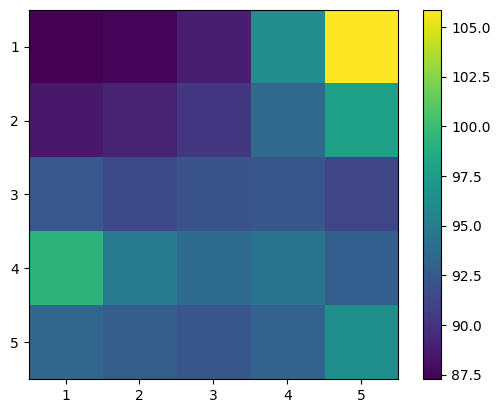

An exmaple of the output of the model is shown below.


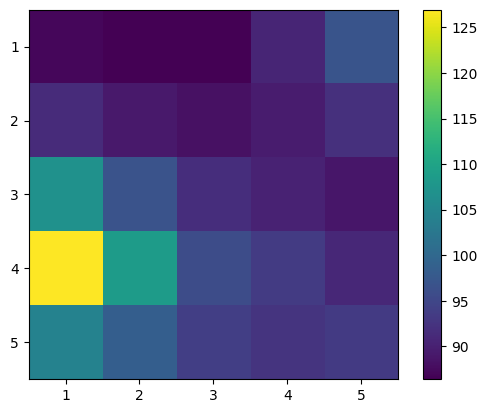

In [ ]:
# Show Example Input + Output
# Note that the 2D heat source can also be expressed as 1D node

import matplotlib.pyplot as plt

# Input
print('An exmaple of the inputs to the model are shown below. They are a heat source coordinate and a temperature map.')
print(Position_Arrays[0])
print("Note that this node can also be expressed as node 15 or [1,4]")
cmap = plt.cm.viridis
plt.imshow(Initial_Temp_Arrays[0], cmap=cmap, extent=[1, 6, 6, 1])
plt.xticks(np.arange(5) + 1.5, np.arange(1, 6))
plt.yticks(np.arange(5) + 1.5, np.arange(1, 6))
plt.colorbar()
plt.show()


# Output
print('An exmaple of the output of the model is shown below.')
cmap = plt.cm.viridis
plt.imshow(Final_Temp_Arrays[0], cmap=cmap,extent=[1, 6, 6, 1])
plt.colorbar()
plt.xticks(np.arange(5) + 1.5, np.arange(1, 6))
plt.yticks(np.arange(5) + 1.5, np.arange(1, 6))
plt.show()


# **Creating Dataloader**

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Create dataset loader class
class CreateDataset(Dataset):

    def __init__(self, branch_in, trunk_in, output):
      self.branch_in = branch_in
      self.trunk_in = trunk_in
      self.output = output

    def __len__(self):
      return len(self.branch_in)

    def __getitem__(self, index):
      return self.branch_in[index], self.trunk_in[index], self.output[index]

# Create a dictionary of dataloaders for training
data_deeponet_dict = {}

for n in range(25):
  data_batches = CreateDataset(train_branch_input_dict[n], train_trunk_input_dict[n], train_output_dict[n])
  batch_size = 100
  data_deeponet = DataLoader(data_batches,batch_size=batch_size, shuffle = True)
  data_deeponet_dict[n] = data_deeponet

val_data_deeponet_dict = {}
for p in range(25):
  val_data_batches = CreateDataset(val_branch_input_dict[p], val_trunk_input_dict[p], val_output_dict[p])
  val_batch_size = 100
  val_data_deeponet = DataLoader(val_data_batches,batch_size=val_batch_size, shuffle = True)
  val_data_deeponet_dict[p] = val_data_deeponet

# **MLP Class**

In [ ]:
import torch.nn as nn

# Construct class for network
class MLP(nn.Module):

    def __init__(self, input_dim, width, depth, out_dim, activation):

        super(MLP, self).__init__()

        # Activations
        if activation == 'tanh':
          self.activation = nn.Tanh()
        elif activation == 'sin':
          self.activation = torch.sin

          # You can also use the class defined below
          # self.activation = Sine()

        # Need to ensure there is at least one hidden layer
        assert depth > 1

        # First hidden layer
        MLP_list = [nn.Linear(input_dim, width)]

        for _ in range(depth - 1):
            MLP_list.append(nn.Linear(width, width))

        MLP_list.append(nn.Linear(width, out_dim))

        self.model = nn.ModuleList(MLP_list)

        def init_weights(layer):
          if isinstance(layer, nn.Linear):
              nn.init.uniform_(layer.weight, -1, 1)
              if layer.bias is not None:
                nn.init.uniform_(layer.bias, -1, 1)

        self.model.apply(init_weights)

    def forward(self, x):
        for layer in self.model:
          if layer == self.model[-1]:
            x = layer(x)
          else:
            x = self.activation(layer(x))

        return x

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)


# **Initialize Model**

In [ ]:
# Initialize Models
import torch
import torch.optim as optim
import torch.nn as nn

# Declare Constants
learn_rate = 1e-5
reg_param = 1e-4
loss_function = nn.MSELoss()
loss_data = []
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

branch_net_dict = {}
trunk_net_dict = {}
optimizer_dict = {}

False


In [ ]:
rows = 25
cols = 500

# Create a 2D list filled with zeros
train_loss_data = [[0] * cols for _ in range(rows)]
val_loss_data = [[0] * cols for _ in range(rows)]

# **Model Dictionary**

In [ ]:
# Create a dictionary of models
# Set this to 0 to 25 for first run. Tune each model as necessary by reinitializing
for n in range(0,25):
  # Generate each network and send to device
  branch_net = MLP(input_dim = 25, width = 25, depth = 12, out_dim = 25, activation = 'tanh')
  trunk_net = MLP(input_dim = 1, width = 25, depth = 12, out_dim = 25, activation = 'tanh')
  branch_net = branch_net.to(device)
  trunk_net = trunk_net.to(device)
  branch_net_dict[n] = branch_net
  trunk_net_dict[n] = trunk_net

  # Combining parameters from both networks
  all_params = list(branch_net.parameters()) + list(trunk_net.parameters())
  optimizer = optim.Adam(all_params, lr = learn_rate, betas = (0.5, 0.9), weight_decay = reg_param)
  optimizer_dict[n] = optimizer


# **Training Loop**

In [ ]:
epochs = 500

# Set this to 0 to 25 for first run. Tune each model as necessary by reinitializing
for m in range(0,25):
  print('Training Model '+str(m))
  for epoch in range(epochs):
    total_train_loss = 0
    for k,data in enumerate(data_deeponet_dict[m]):
      branch_data, trunk_data, training_output = data

      # Input to model
      optimizer_dict[m].zero_grad()
      trunk_data = trunk_data.to(device)
      branch_data = branch_data.to(device)
      training_output = training_output.to(device)

      # Calc output of branch and trunk
      branch_output_pred = branch_net_dict[m](branch_data)
      trunk_output_pred = trunk_net_dict[m](trunk_data)

      # Take the dot product to get the output and find the loss
      total_output_pred = torch.sum(branch_output_pred*trunk_output_pred, dim = -1) #dot product
      training_output = torch.reshape(training_output, (batch_size,))
      loss = loss_function(training_output, total_output_pred) # Calculate loss
      total_train_loss += loss.item()

      # Backpropagation
      loss.backward()
      optimizer_dict[m].step()

    # Storing Loss Data
    # Check if the specified row index exists, if not, extend the list with empty rows
    avg_train_loss = total_train_loss / len(data_deeponet_dict[m])

    #while len(train_loss_data) <= m:
    #  train_loss_data.append([])

    train_loss_data[m][epoch] = avg_train_loss

    # Printing Loss
    #if epoch % 100 == 0:
    #  print(f"Epoch {epoch: .3f}, Loss: {loss: .3f}")

    # Validation Loop
    total_val_loss = 0
    with torch.no_grad():
        for j, val_data in enumerate(val_data_deeponet_dict[m]):
            val_branch_data, val_trunk_data, val_output = val_data

            val_branch_data = val_branch_data.to(device)
            val_trunk_data = val_trunk_data.to(device)
            val_output = val_output.to(device)

            val_branch_output_pred = branch_net_dict[m](val_branch_data)
            val_trunk_output_pred = trunk_net_dict[m](val_trunk_data)

            total_output_pred = torch.sum(val_branch_output_pred * val_trunk_output_pred, dim=-1) #dot product
            val_output = torch.reshape(val_output, (val_batch_size,))

            val_loss = loss_function(val_output, total_output_pred)
            total_val_loss += val_loss.item()

    # Storing Val Loss Data
    # Check if the specified row index exists, if not, extend the list with empty rows
    avg_val_loss = total_val_loss / len(val_data_deeponet_dict[m])
    #while len(val_loss_data) <= m:
    # val_loss_data.append([])
    #val_loss_data[m].append(avg_val_loss)
    val_loss_data[m][epoch] = avg_val_loss


    # Printing Loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}")


Training Model 9
Epoch 0, Training Loss: 13447.089, Validation Loss: 13311.682
Epoch 100, Training Loss: 61.005, Validation Loss: 70.131
Epoch 200, Training Loss: 43.898, Validation Loss: 47.020
Epoch 300, Training Loss: 31.714, Validation Loss: 34.117
Epoch 400, Training Loss: 28.633, Validation Loss: 28.289


# **Plot Loss**

The average final validation loss is: 35.77912605285644
The average final train loss is: 22.04672182474747


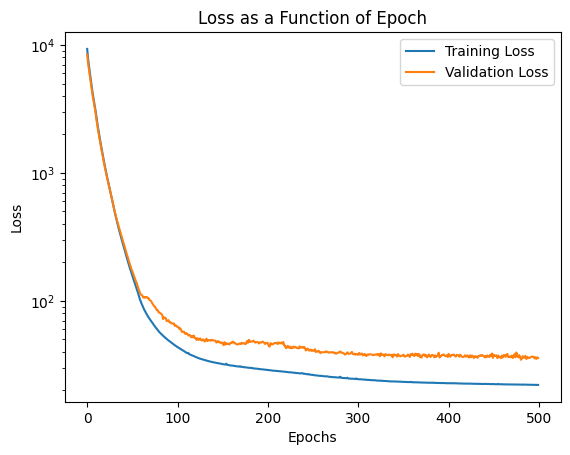

In [ ]:
import matplotlib.pyplot as plt
last_column = [row[-1] for row in val_loss_data]
last_column_train = [row1[-1] for row1 in train_loss_data]

print("The average final validation loss is: " + str(np.mean(last_column)))
print("The average final train loss is: " + str(np.mean(last_column_train)))

transposed_matrix_train = list(map(list, zip(*train_loss_data)))
transposed_matrix_val = list(map(list, zip(*val_loss_data)))

# Calculate the average of each column
train_loss_averages = [sum(col) / len(col) for col in transposed_matrix_train]
val_loss_averages = [sum(col1) / len(col1) for col1 in transposed_matrix_val]

plt.semilogy(train_loss_averages, label='Training Loss')
plt.semilogy(val_loss_averages, label='Validation Loss')

#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss as a Function of Epoch')
plt.show()

# **Plot from Homogeneous Input**

[[90 90 90 90 90]
 [90 90 90 90 90]
 [90 90 90 90 90]
 [90 90 90 90 90]
 [90 90 90 90 90]]
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])


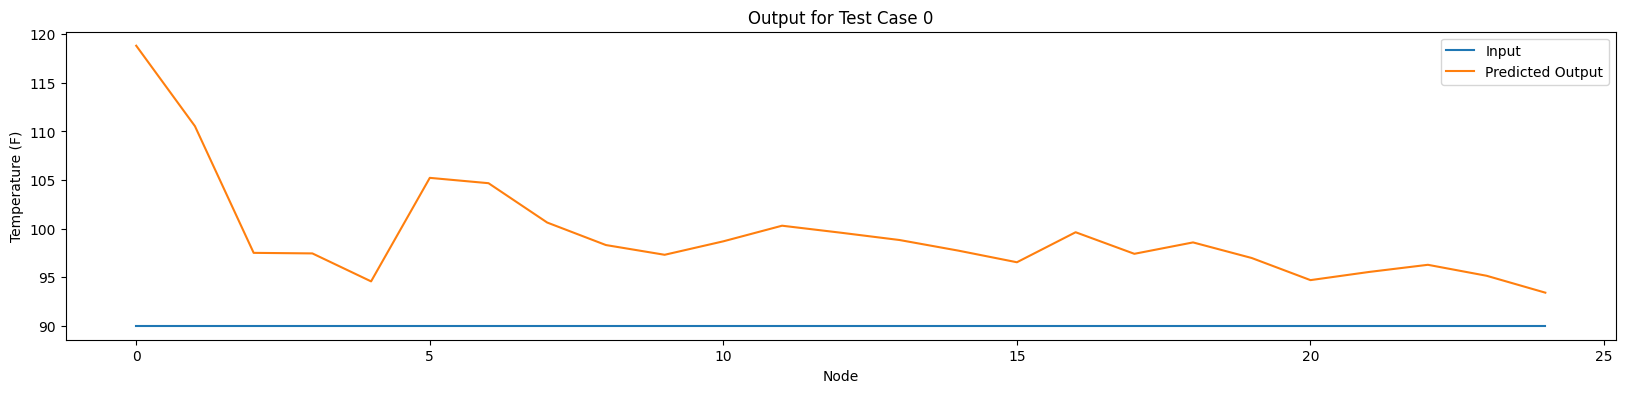

Homogenous Input Shown Below.


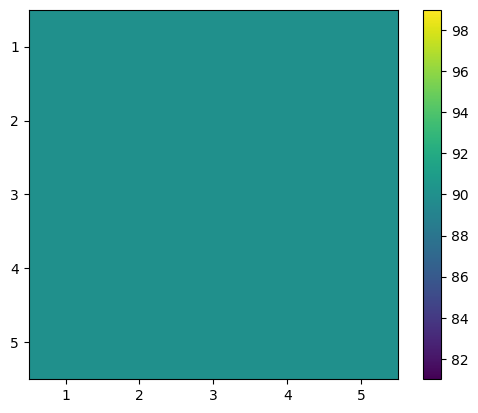

Predicted Ouput Shown Below.


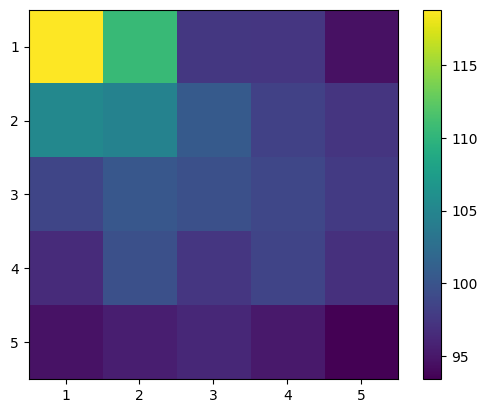

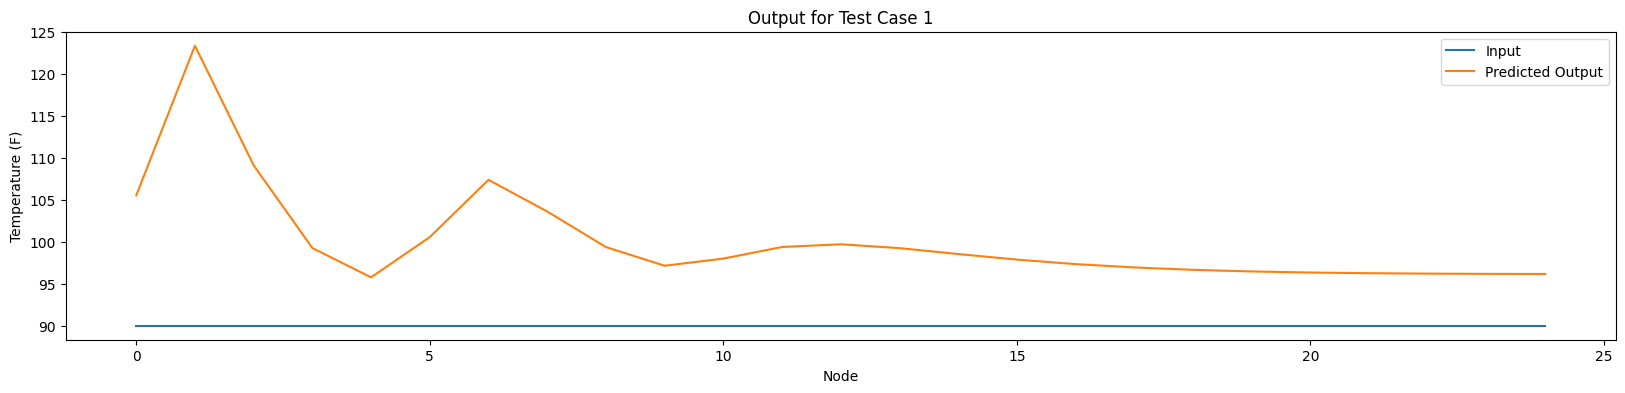

Homogenous Input Shown Below.


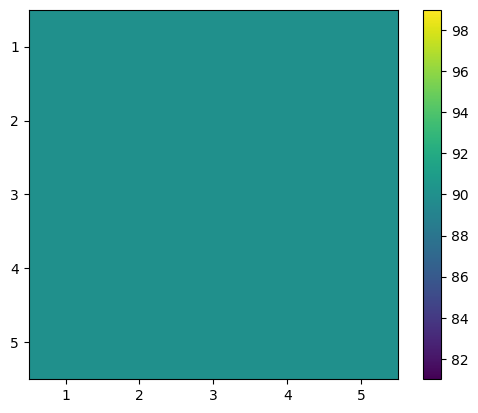

Predicted Ouput Shown Below.


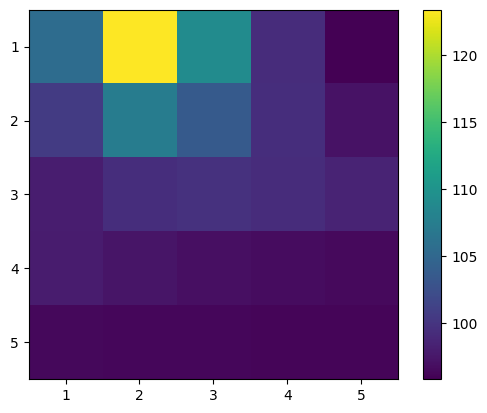

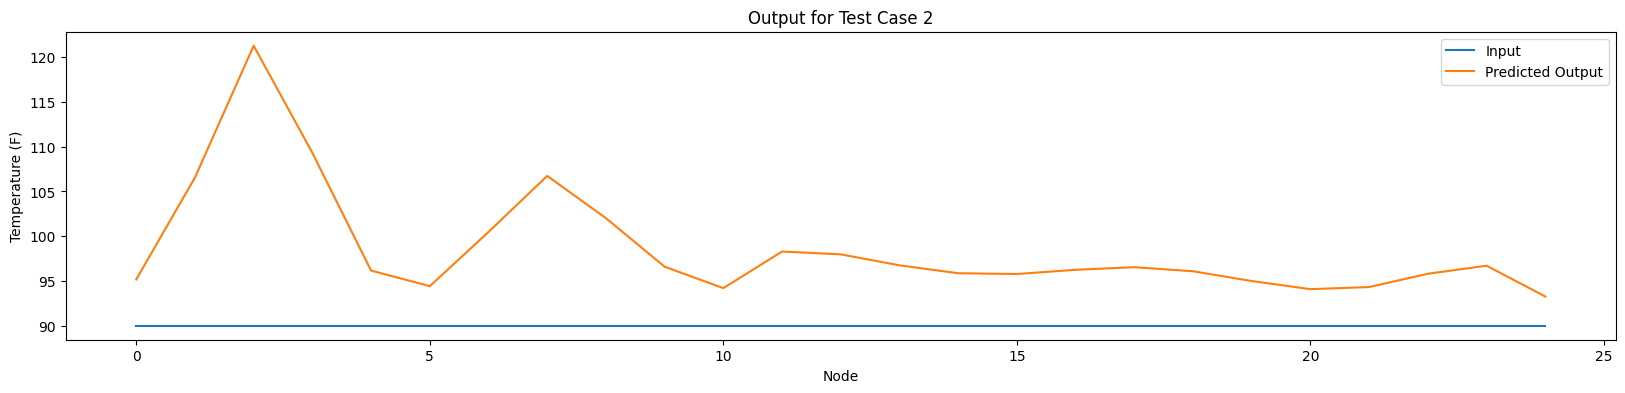

Homogenous Input Shown Below.


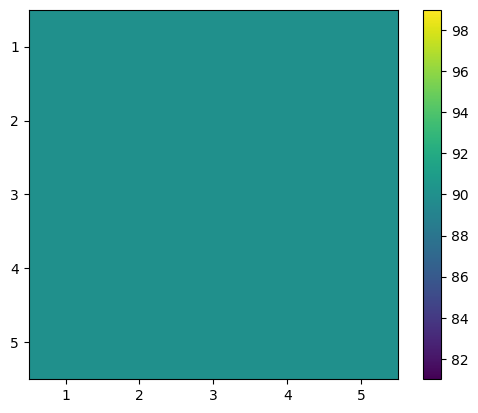

Predicted Ouput Shown Below.


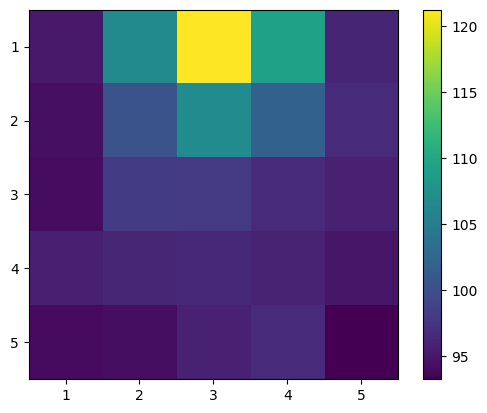

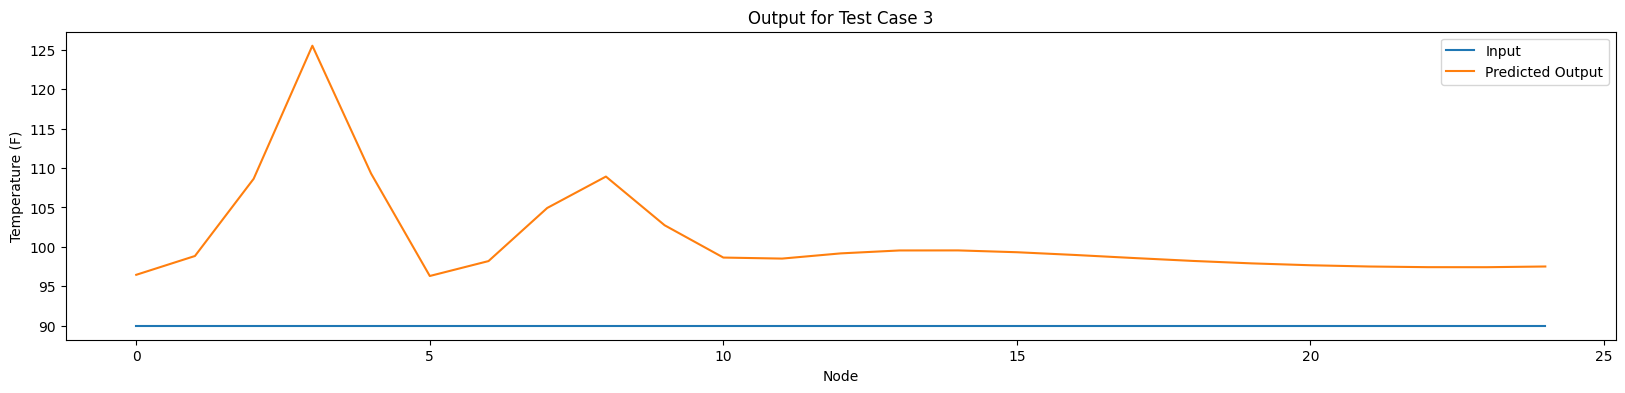

Homogenous Input Shown Below.


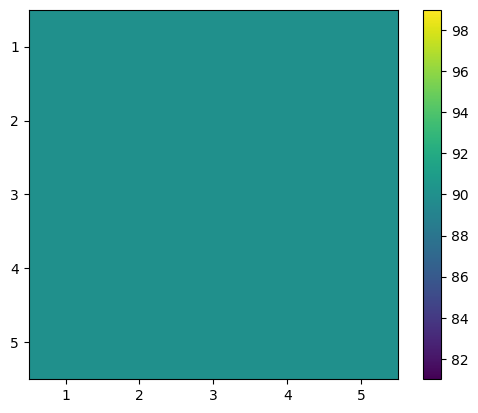

Predicted Ouput Shown Below.


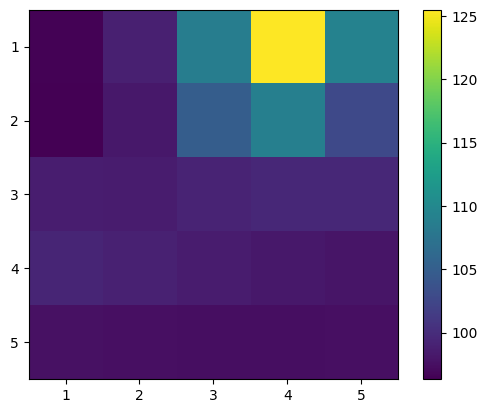

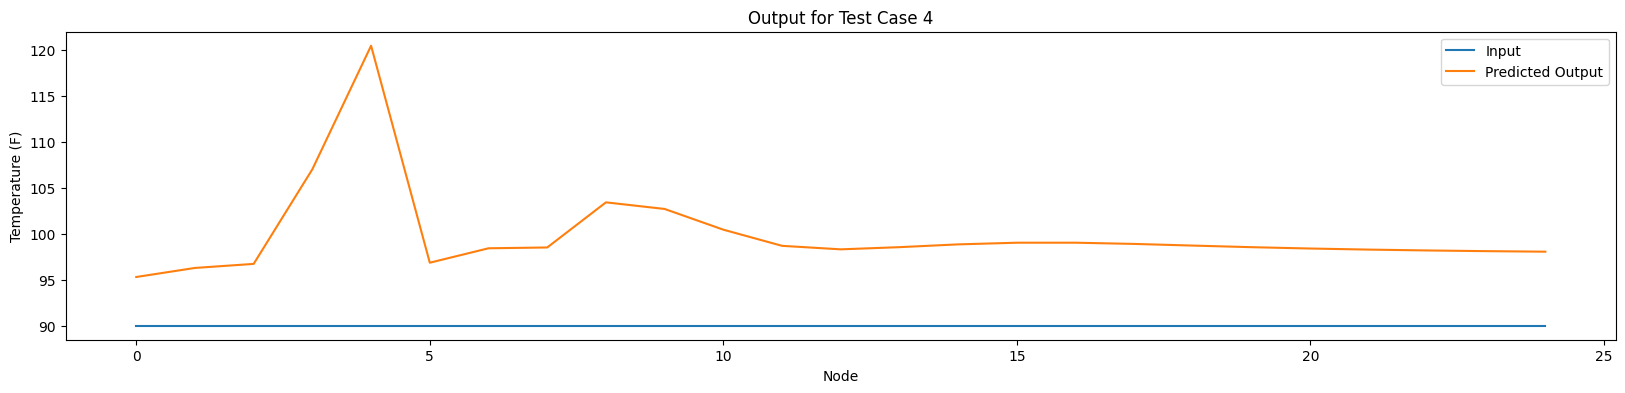

Homogenous Input Shown Below.


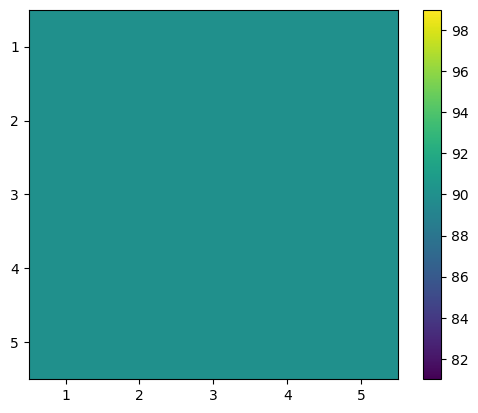

Predicted Ouput Shown Below.


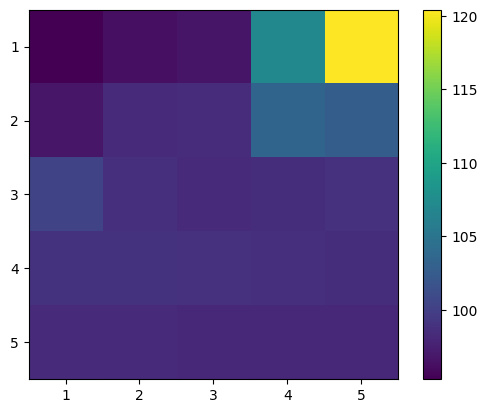

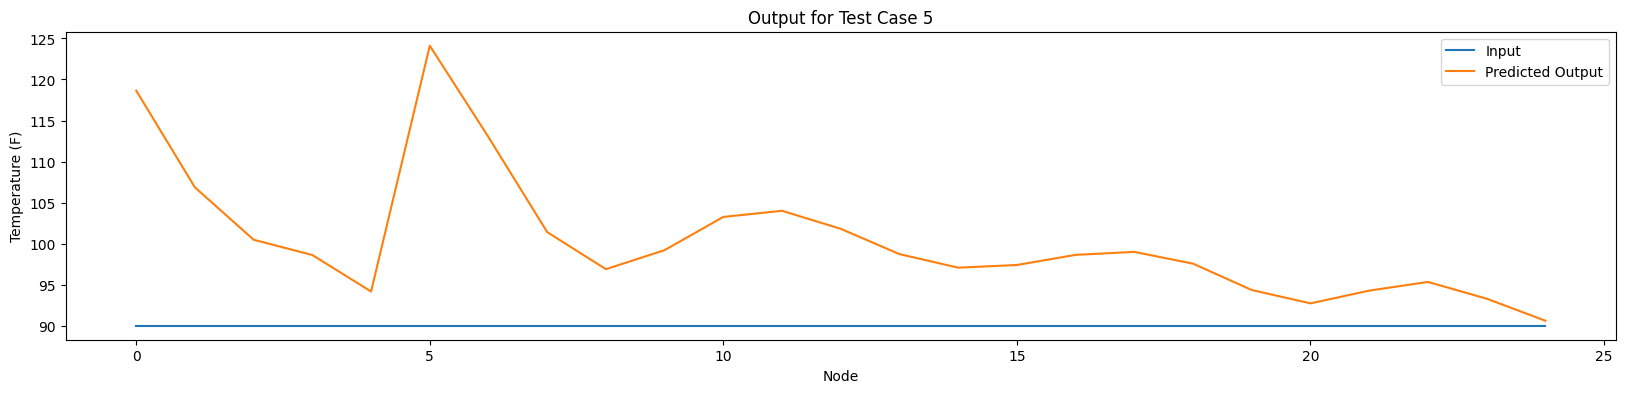

Homogenous Input Shown Below.


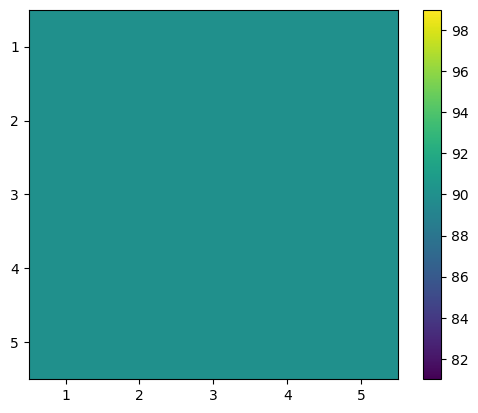

Predicted Ouput Shown Below.


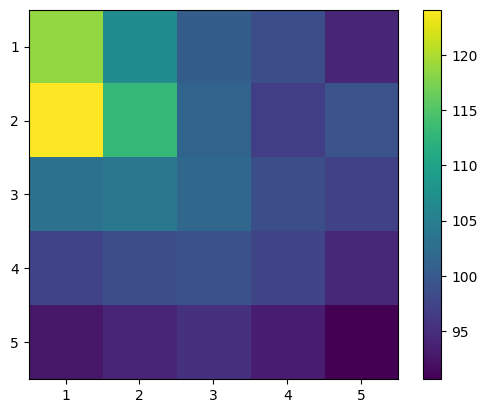

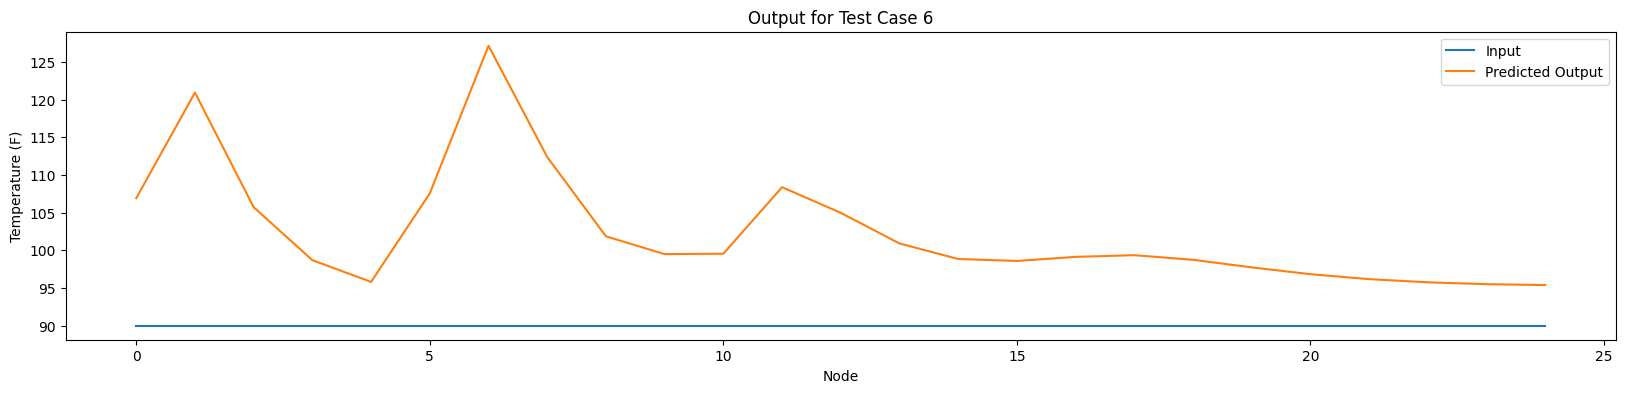

Homogenous Input Shown Below.


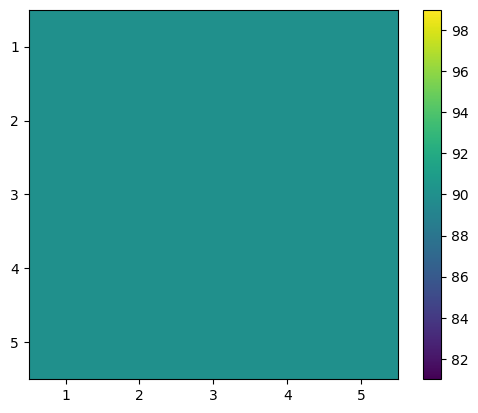

Predicted Ouput Shown Below.


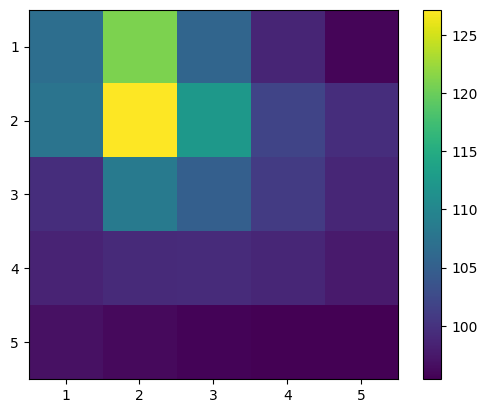

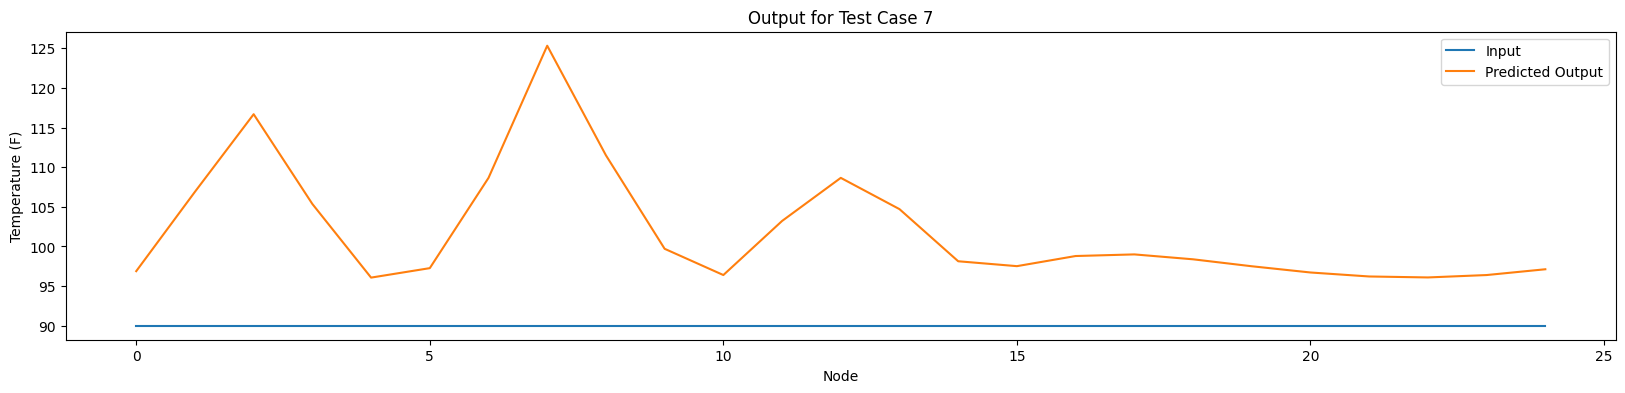

Homogenous Input Shown Below.


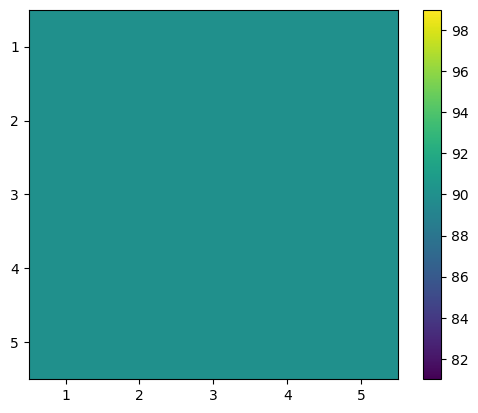

Predicted Ouput Shown Below.


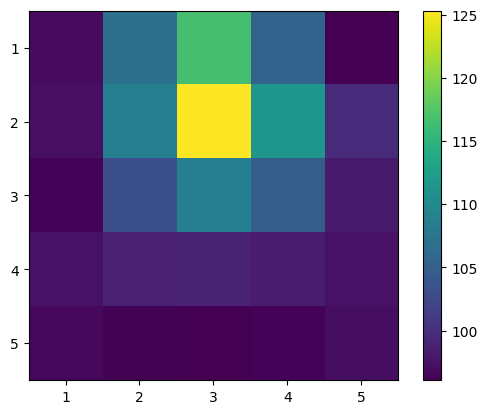

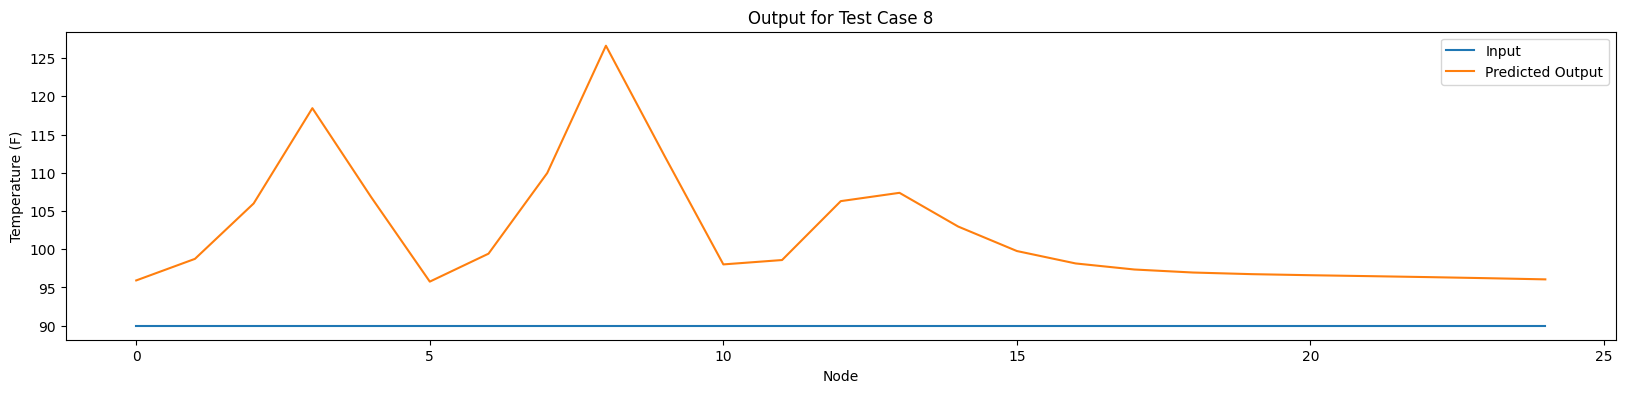

Homogenous Input Shown Below.


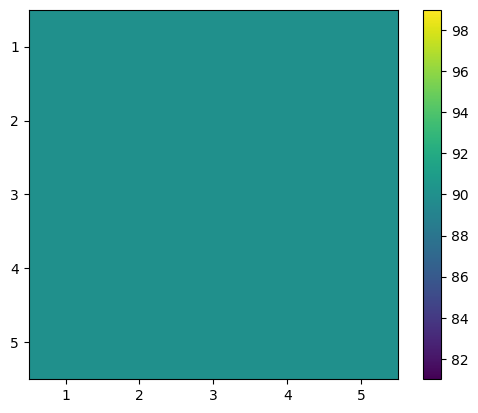

Predicted Ouput Shown Below.


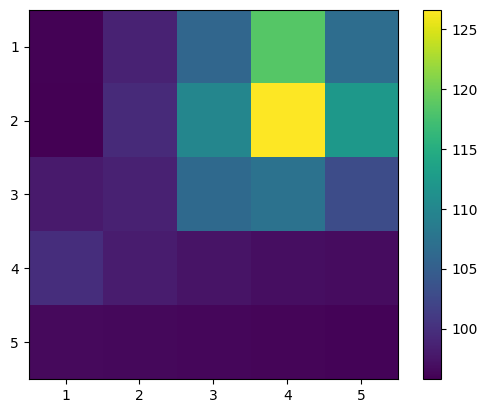

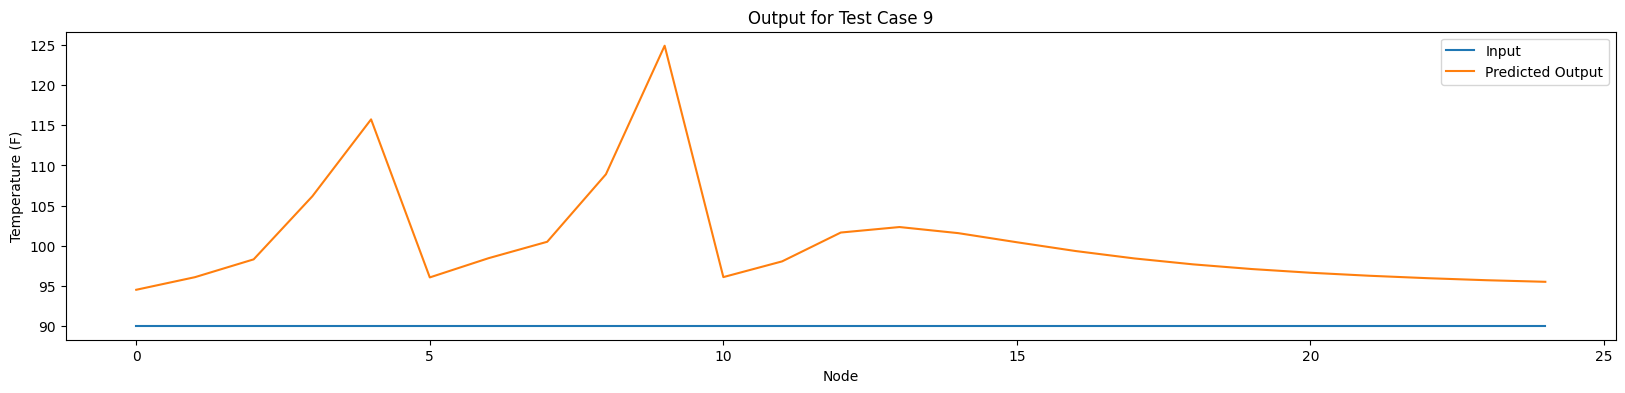

Homogenous Input Shown Below.


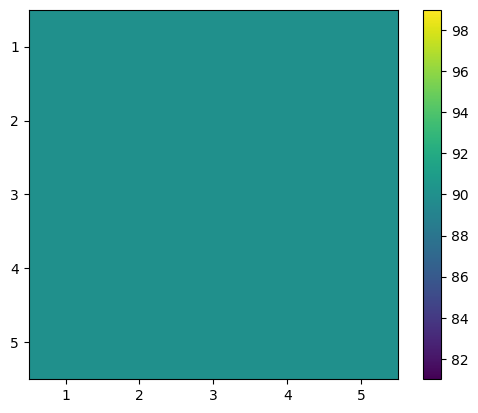

Predicted Ouput Shown Below.


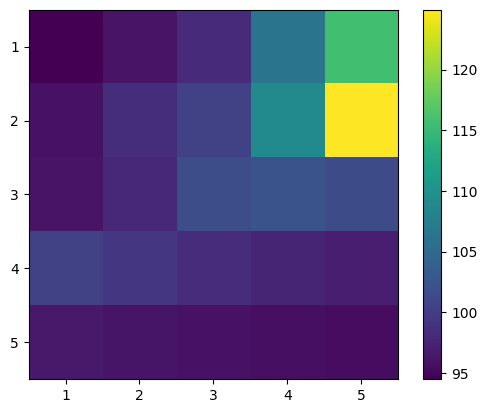

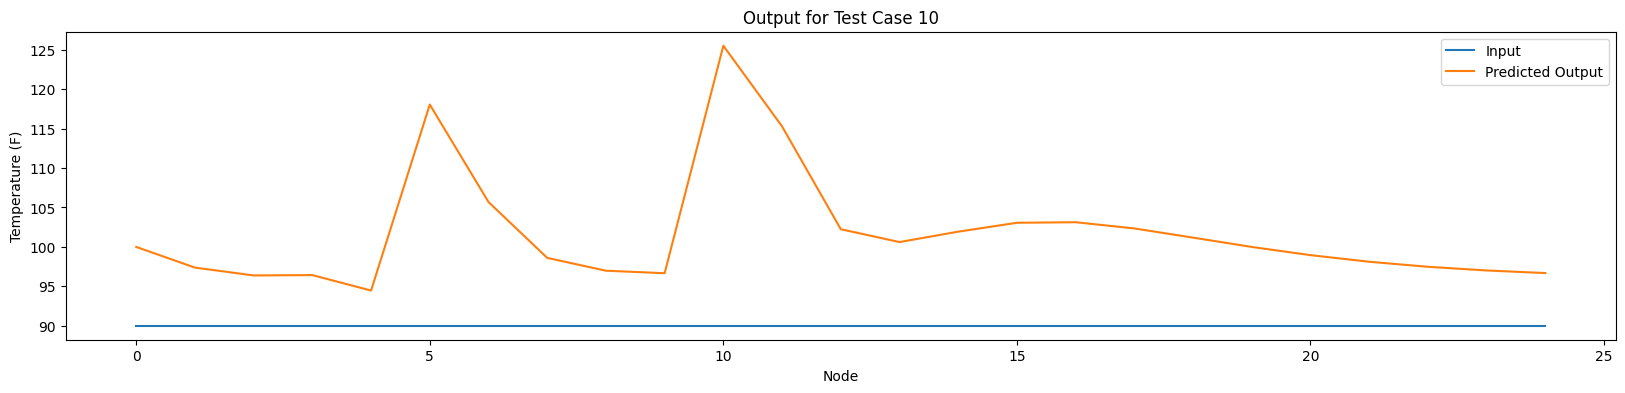

Homogenous Input Shown Below.


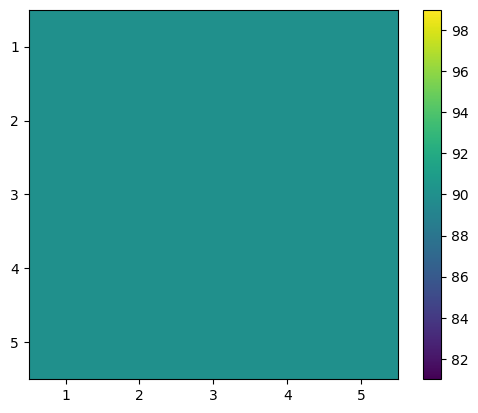

Predicted Ouput Shown Below.


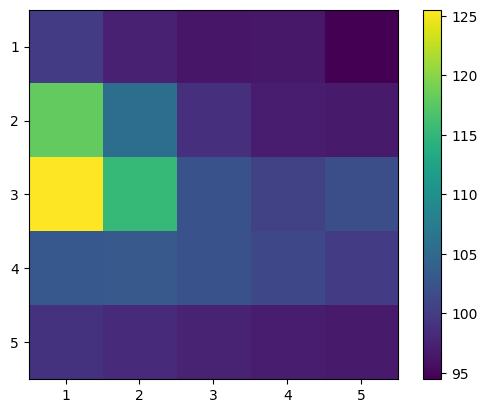

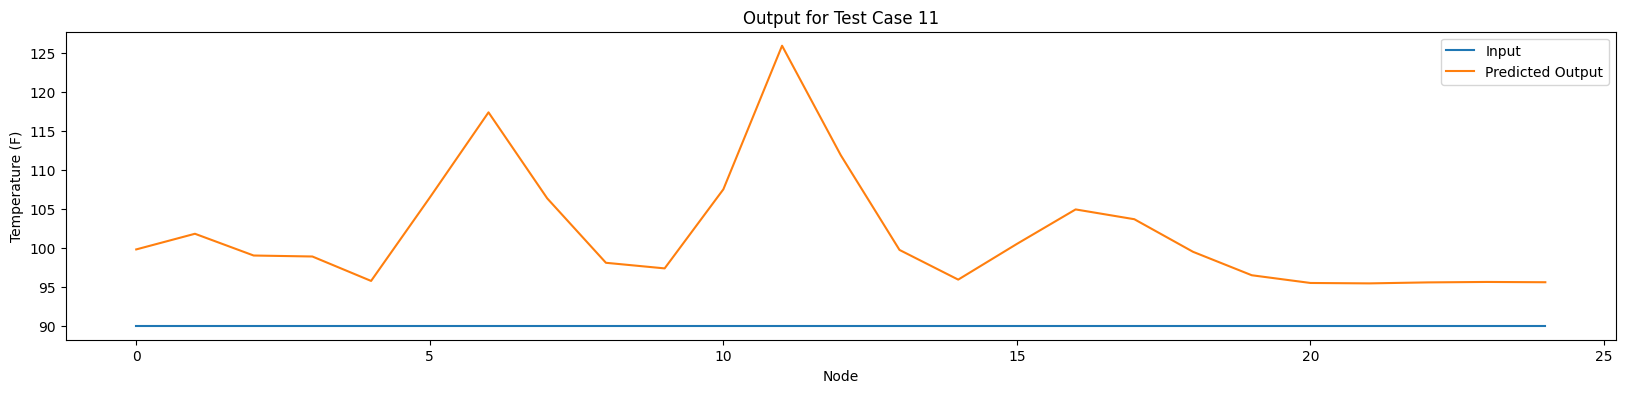

Homogenous Input Shown Below.


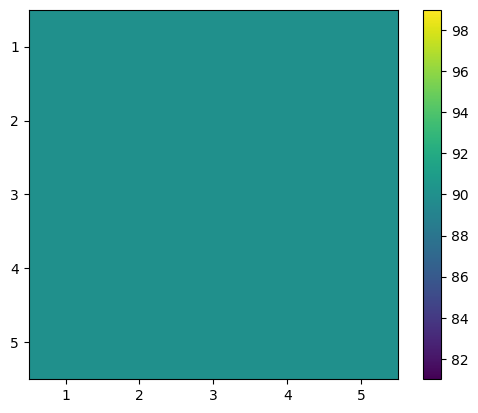

Predicted Ouput Shown Below.


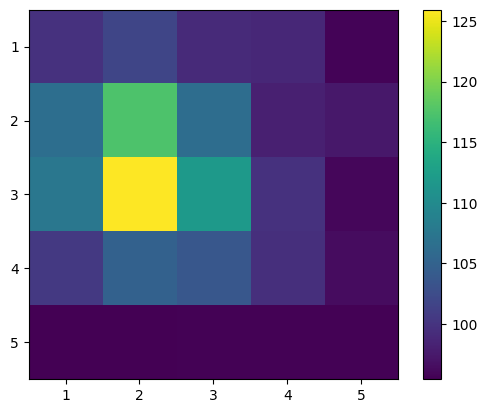

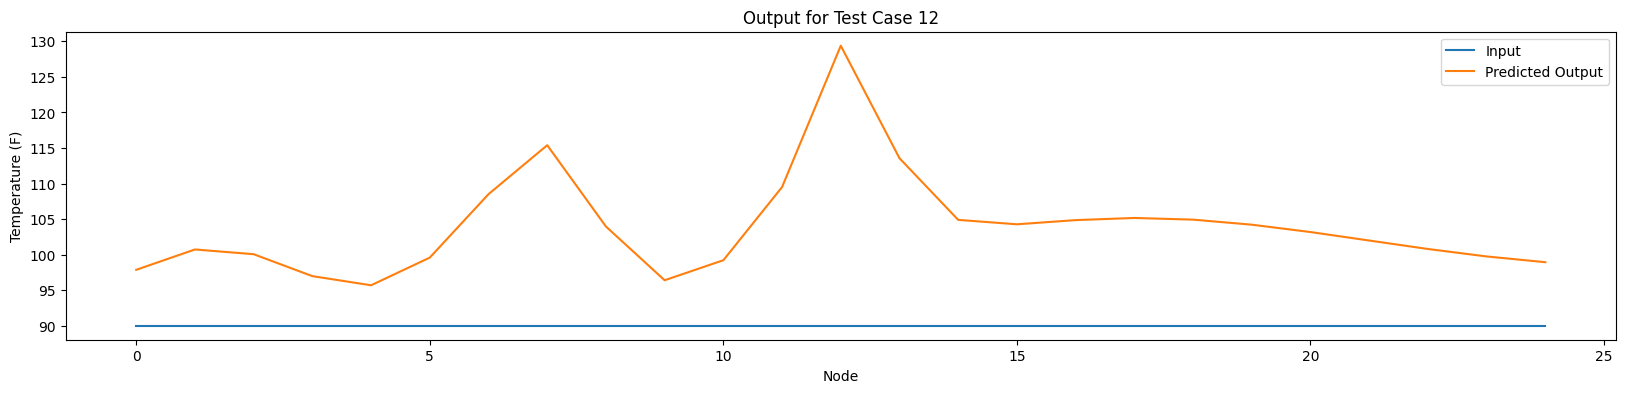

Homogenous Input Shown Below.


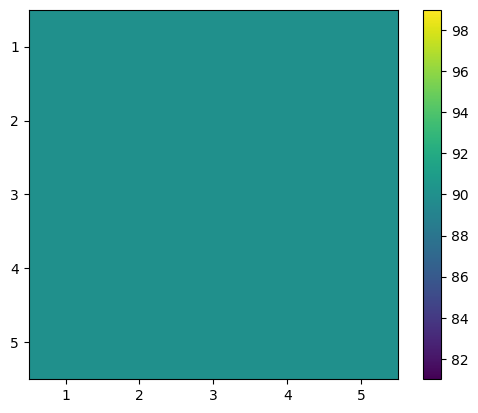

Predicted Ouput Shown Below.


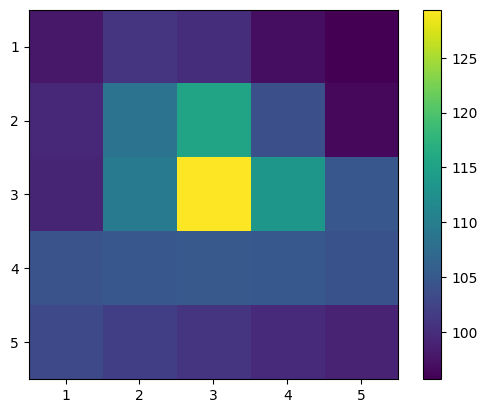

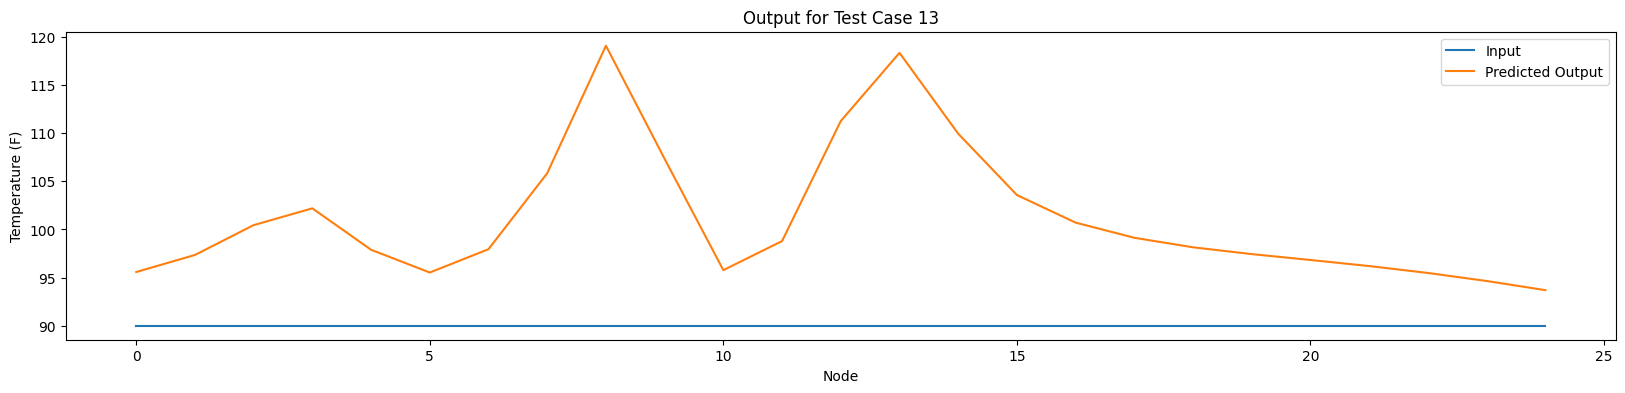

Homogenous Input Shown Below.


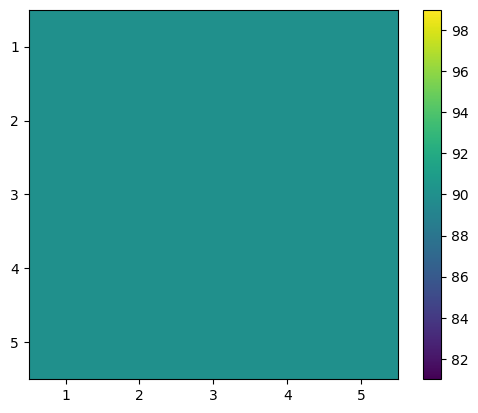

Predicted Ouput Shown Below.


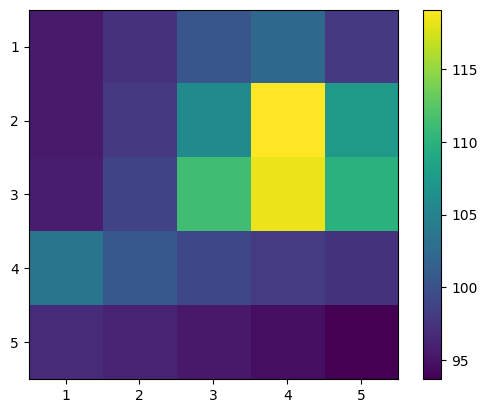

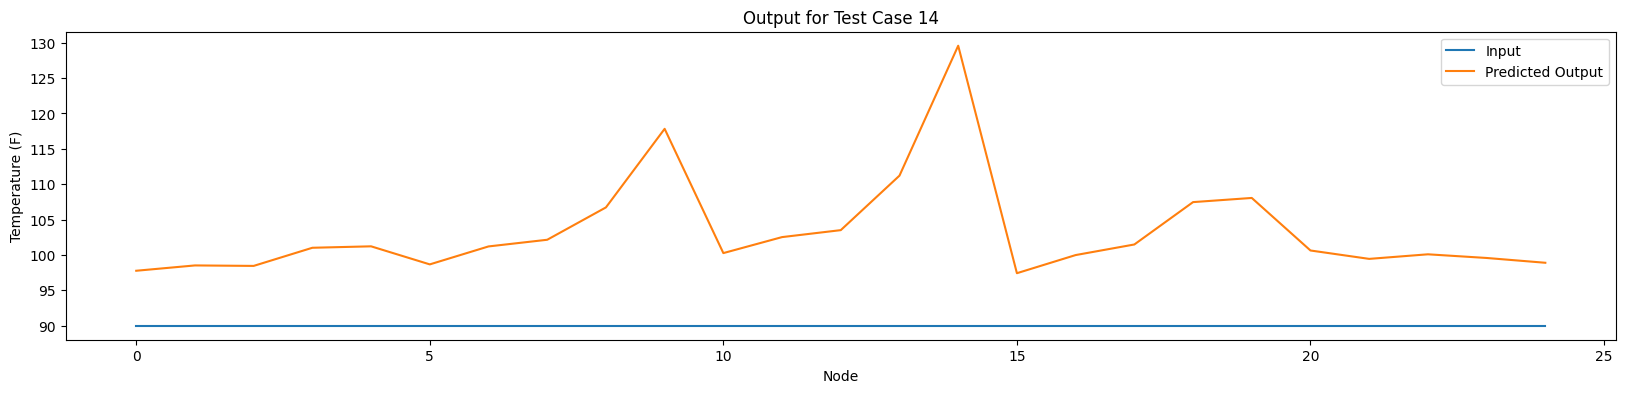

Homogenous Input Shown Below.


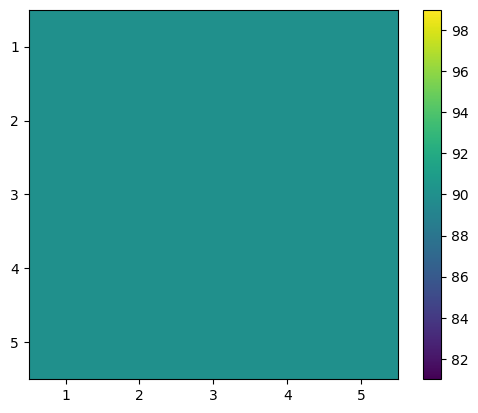

Predicted Ouput Shown Below.


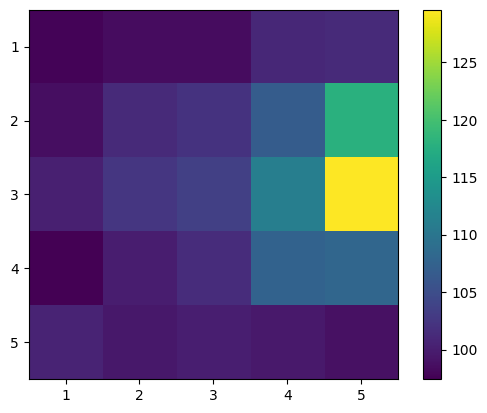

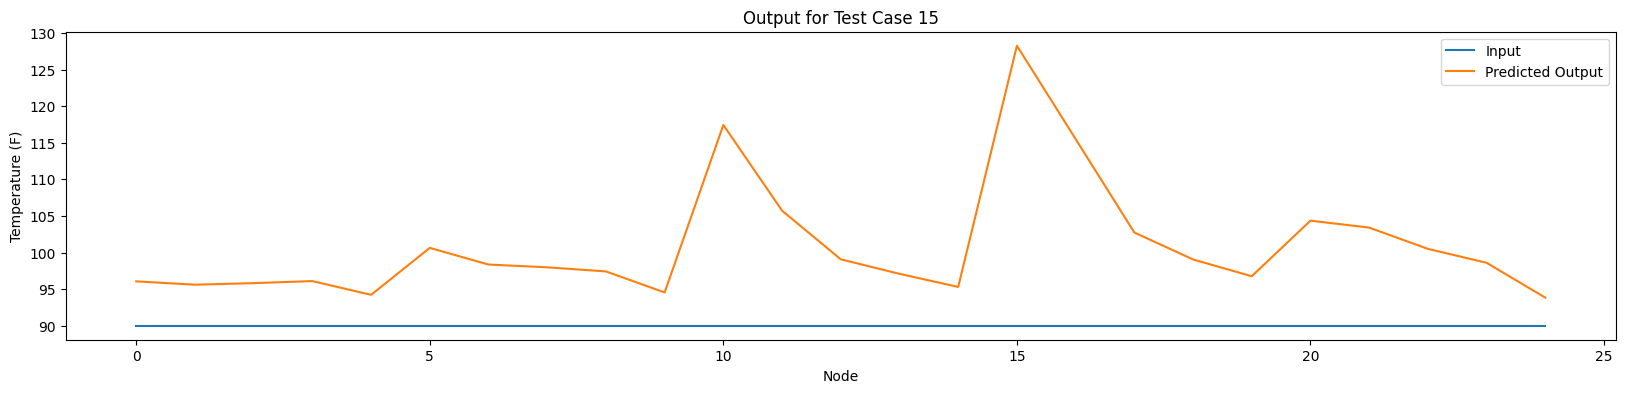

Homogenous Input Shown Below.


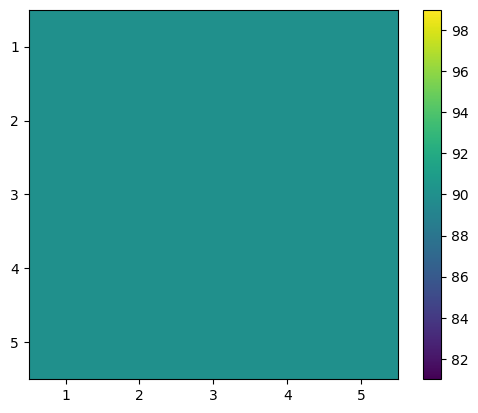

Predicted Ouput Shown Below.


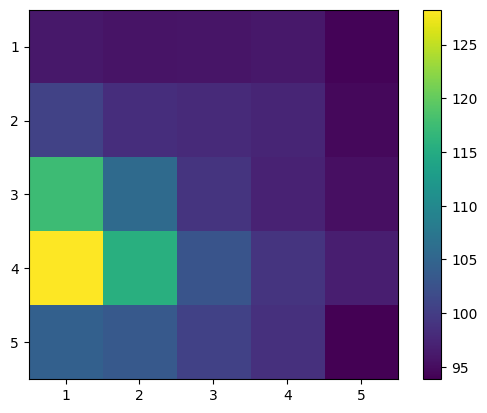

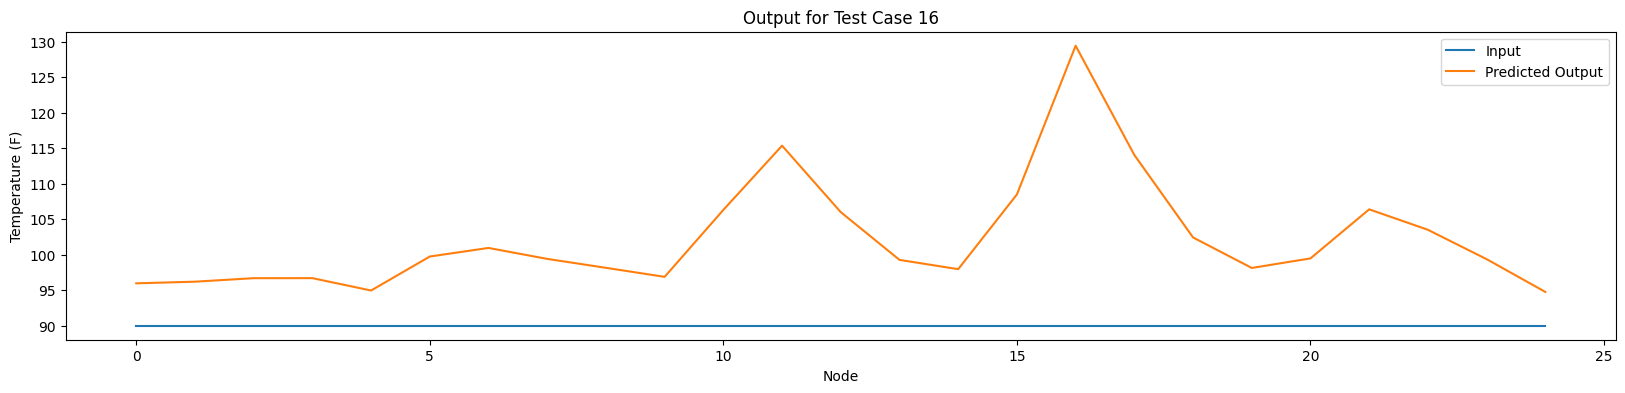

Homogenous Input Shown Below.


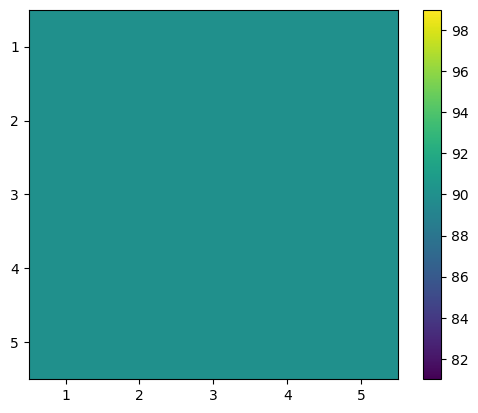

Predicted Ouput Shown Below.


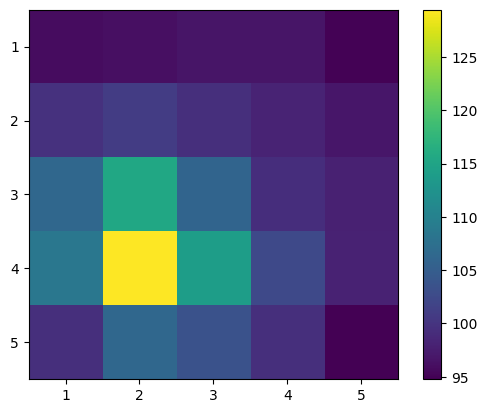

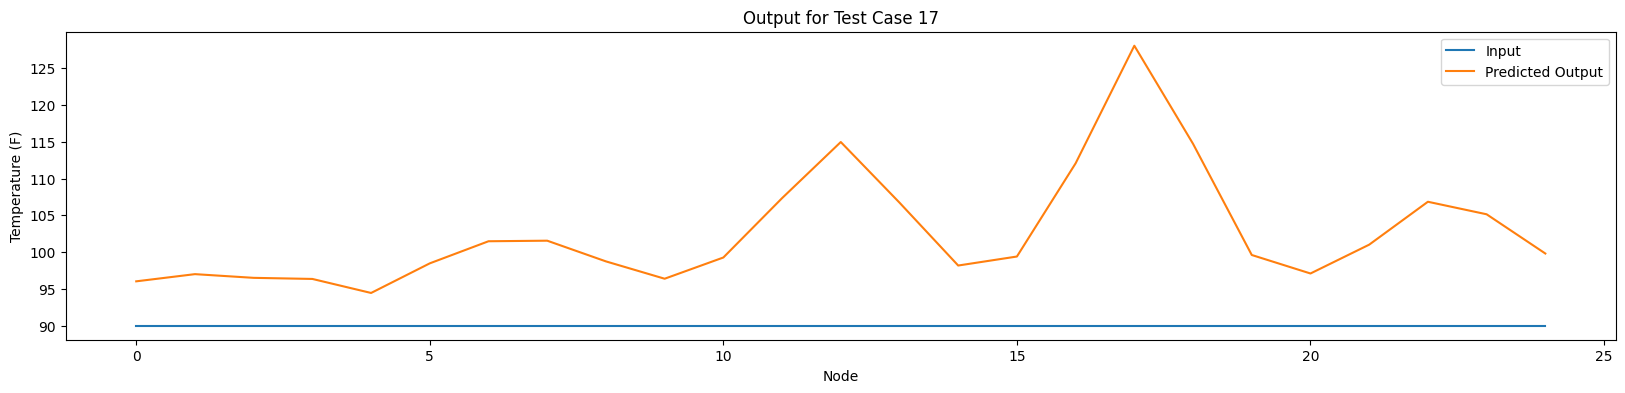

Homogenous Input Shown Below.


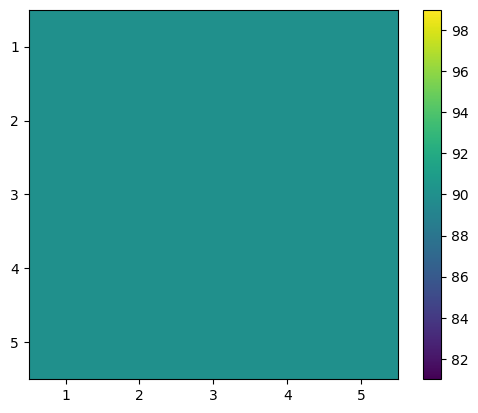

Predicted Ouput Shown Below.


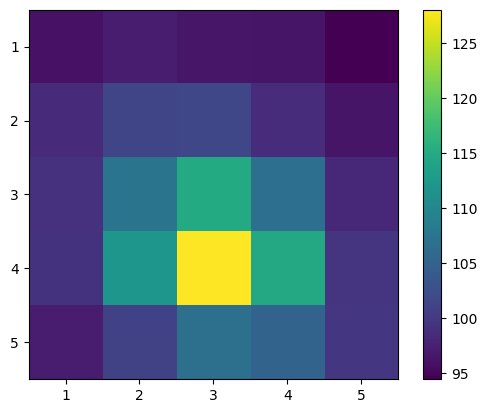

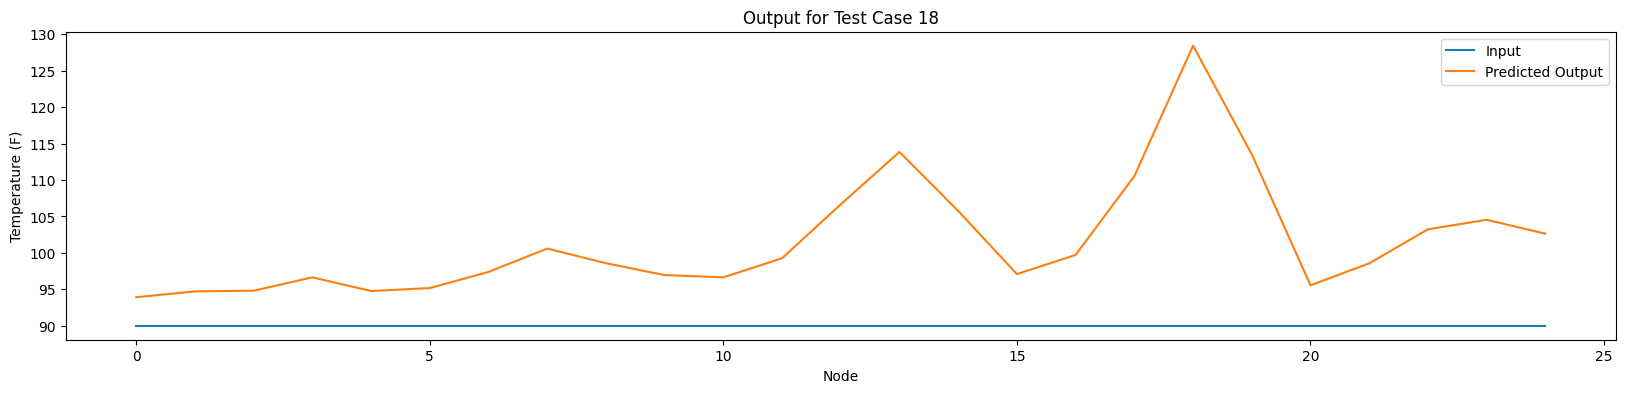

Homogenous Input Shown Below.


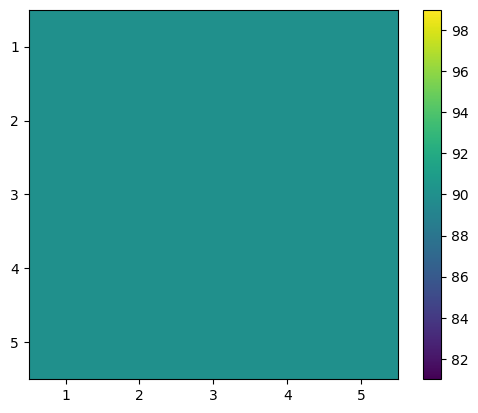

Predicted Ouput Shown Below.


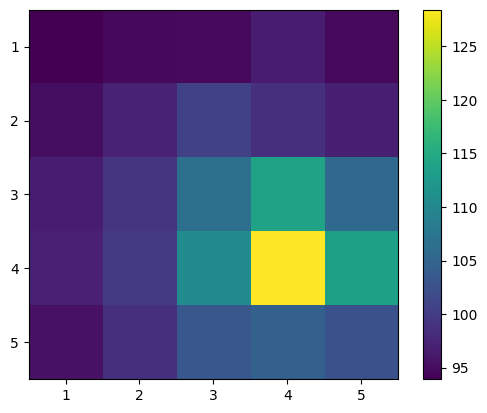

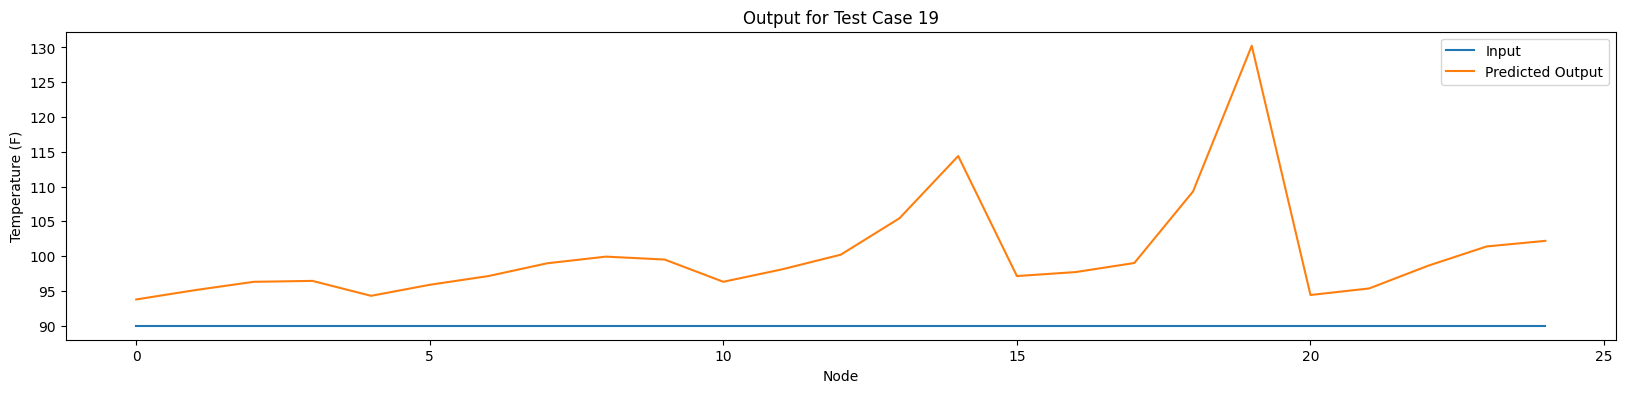

Homogenous Input Shown Below.


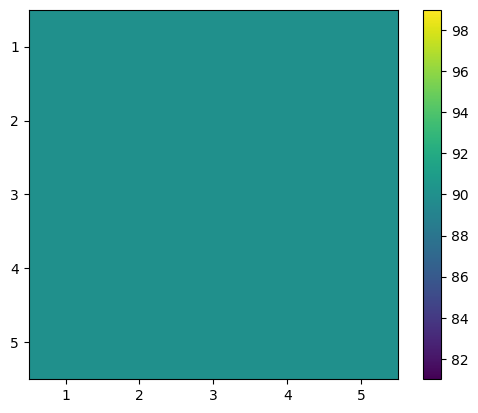

Predicted Ouput Shown Below.


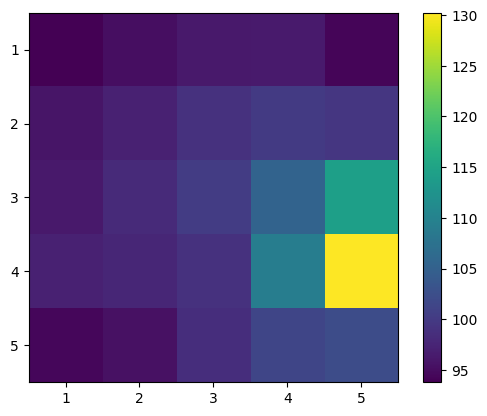

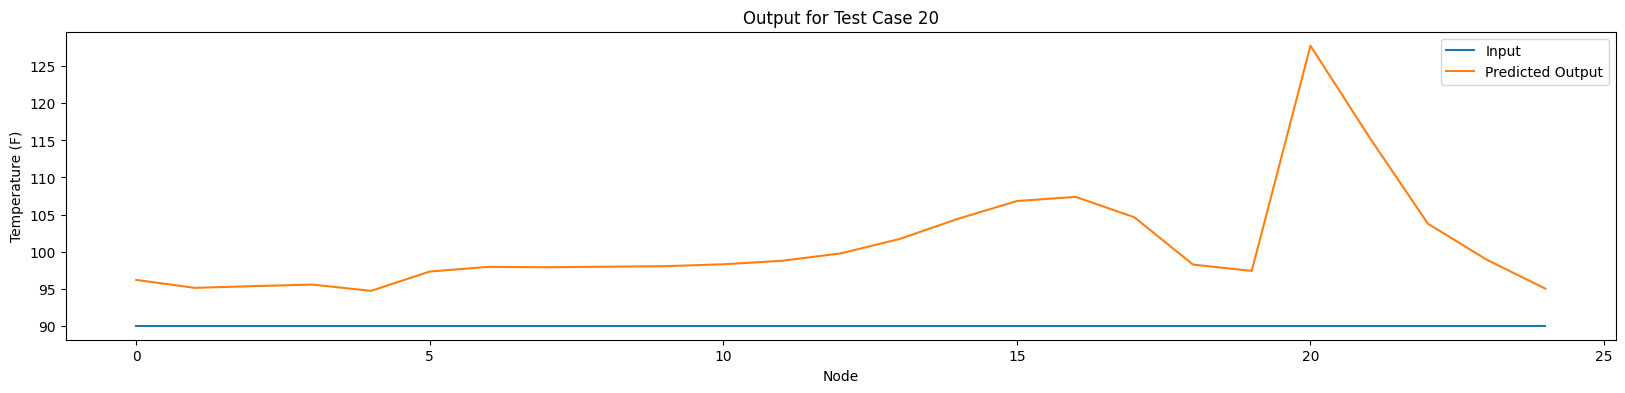

Homogenous Input Shown Below.


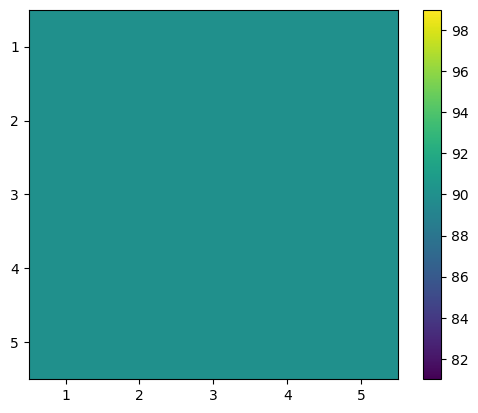

Predicted Ouput Shown Below.


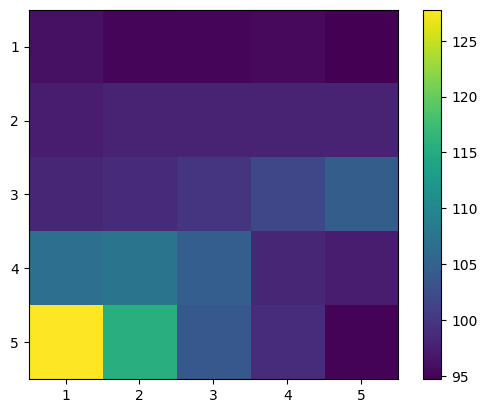

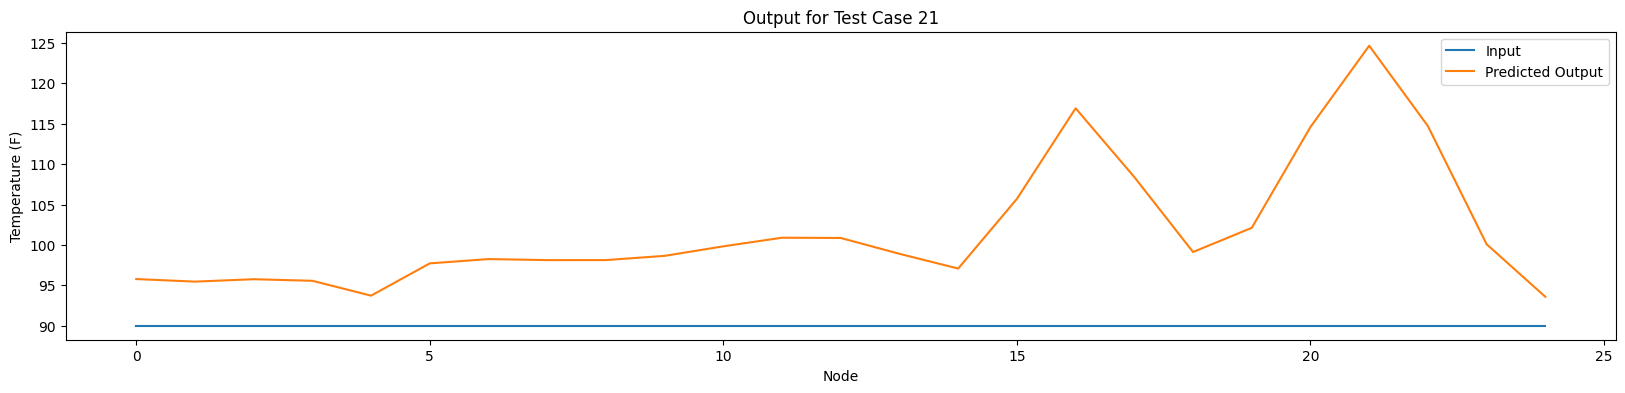

Homogenous Input Shown Below.


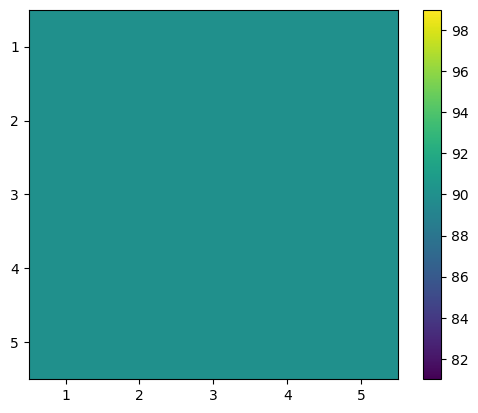

Predicted Ouput Shown Below.


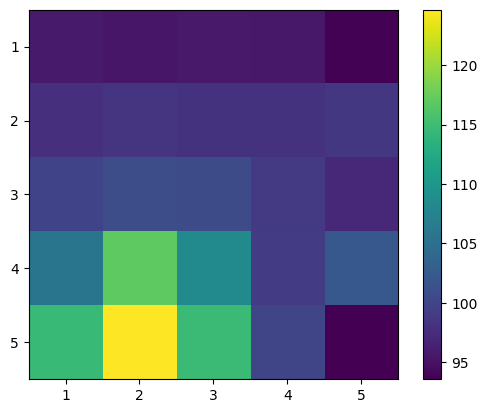

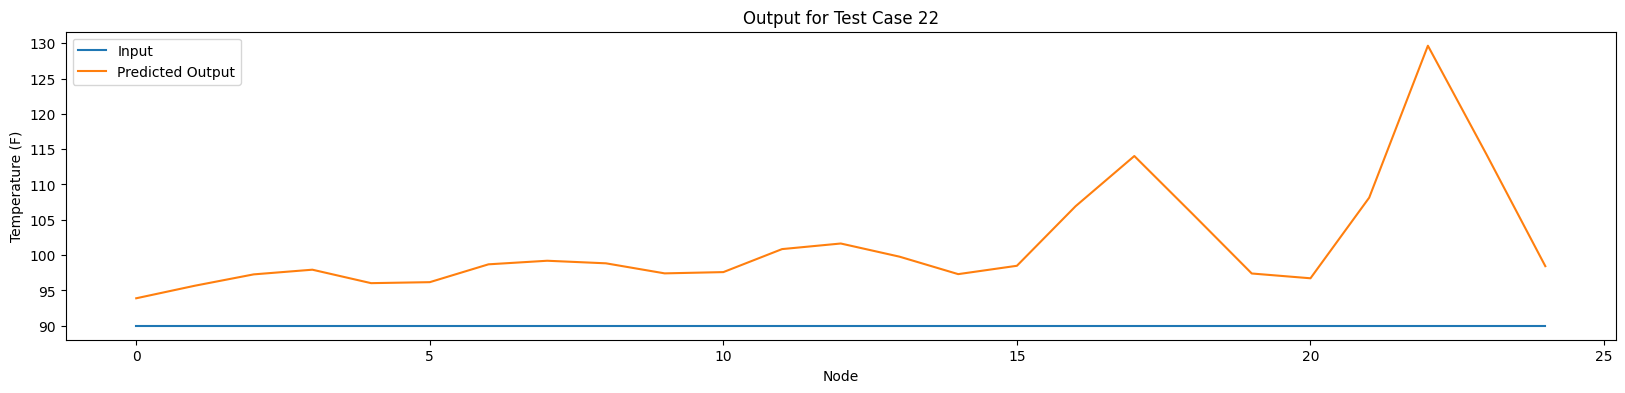

Homogenous Input Shown Below.


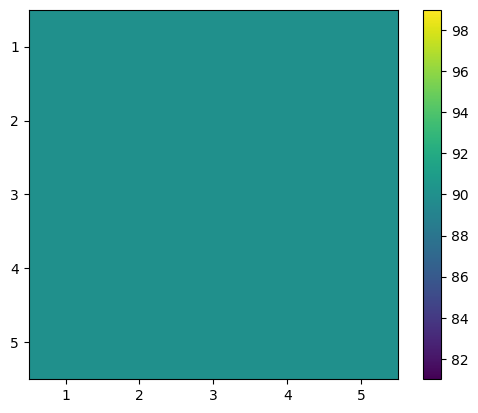

Predicted Ouput Shown Below.


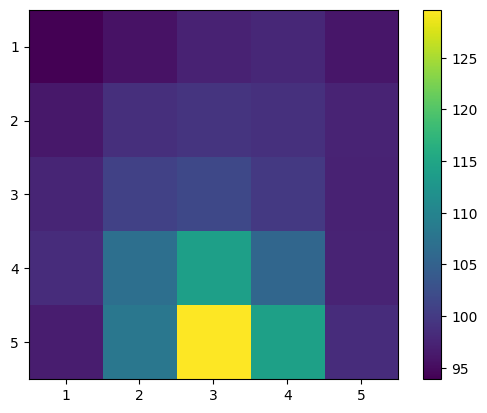

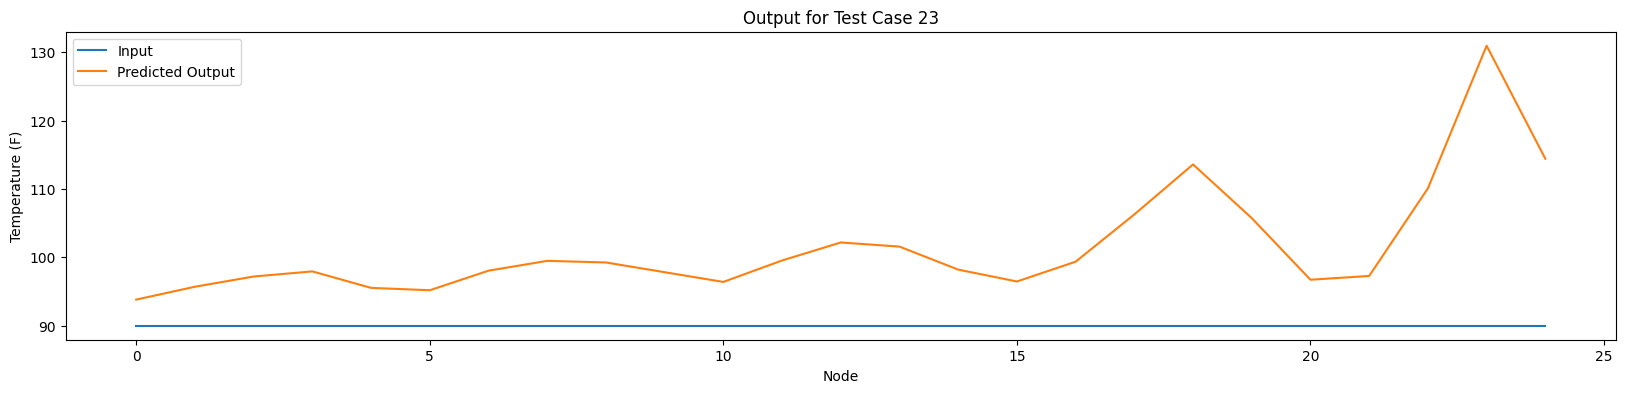

Homogenous Input Shown Below.


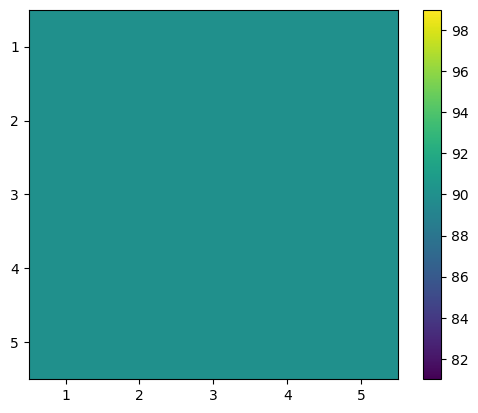

Predicted Ouput Shown Below.


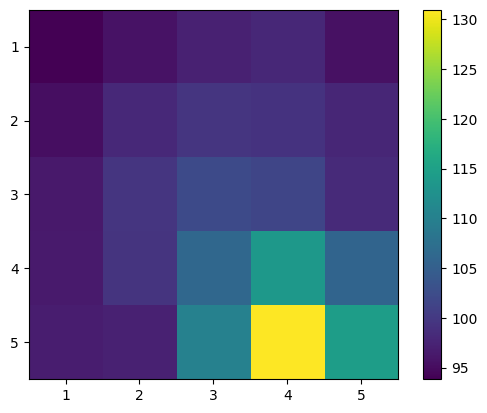

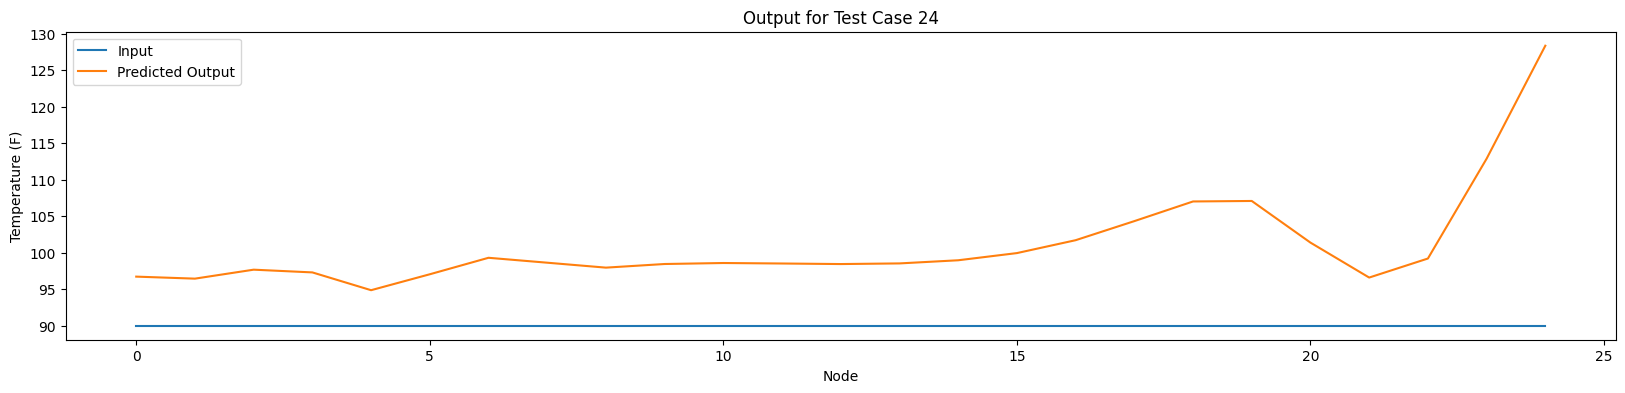

Homogenous Input Shown Below.


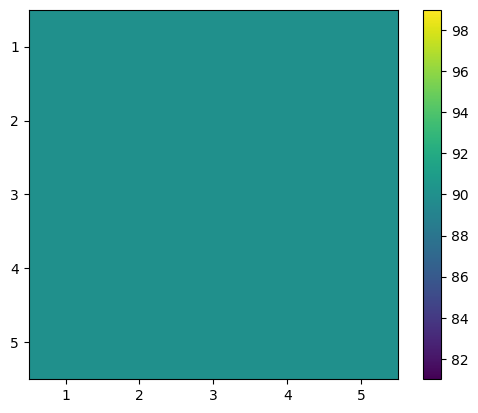

Predicted Ouput Shown Below.


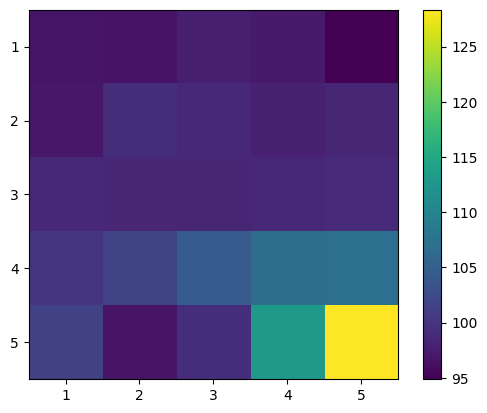

In [ ]:
# This is a sanity check for if the output of the model make sense. Simply input an array at 90deg F and ensure that the heated node becomes hotter
import matplotlib.pyplot as plt
import numpy as np

# Create an example temperature input (homogeous temp)
example_temp_input = np.full((5, 5), 90)
initial_temp_torch = torch.tensor(example_temp_input,dtype=torch.float32)
initial_temp_reshape = torch.reshape(initial_temp_torch, (1, 25))
initial_temp_reshape = initial_temp_reshape.to(device)
print(example_temp_input)

# Create a linspace of nodes to evalute at
example_trunk_input = torch.linspace(0, 24, steps=25)
example_trunk_input = example_trunk_input.to(device)
print(example_trunk_input)

# Evaluate each of the models
for i in range(0,25):
  val_pred_output_list = [] # Initialize an array to hold the 25 outputs for each trunk input
  with torch.no_grad():
    # Input all of the trunk inputs to each model
    for p in range(25):
      # Branch and Trunk Prediction
      val_branch_pred = branch_net_dict[i](initial_temp_reshape)
      trunk_in_val = torch.reshape(example_trunk_input[p],(-1,1))
      val_trunk_pred = trunk_net_dict[i](trunk_in_val)

      # Dot Product and append to the list for a full array output
      val_pred_output = torch.sum(val_trunk_pred*val_branch_pred, dim = -1)
      val_pred_output = val_pred_output.to('cpu').numpy()
      val_pred_output_list.append(val_pred_output)

  # Plot 1 - Input, Ouput, Prediction
  plt.figure(figsize=(20, 4))  # Set the figure size
  plt.subplot(1,1,1)
  plt.plot(example_trunk_input.to('cpu').numpy(),example_temp_input.flatten(),label='Input')
  plt.plot(example_trunk_input.to('cpu').numpy(),np.reshape(val_pred_output_list,-1),label='Predicted Output')
  plt.legend()
  plt.xlabel('Node')
  plt.ylabel('Temperature (F)')
  plt.title('Output for Test Case ' + str(i))
  plt.show()

  # Plot the 5x5 Input
  print('Homogenous Input Shown Below.')
  cmap = plt.cm.viridis
  plt.imshow(example_temp_input, cmap=cmap, extent=[1, 6, 6, 1])
  plt.xticks(np.arange(5) + 1.5, np.arange(1, 6))
  plt.yticks(np.arange(5) + 1.5, np.arange(1, 6))
  plt.colorbar()
  plt.show()

  # Plot the 5x5 Output
  print('Predicted Ouput Shown Below.')
  pred_out_5x5 = np.reshape(val_pred_output_list,(5,5))
  cmap = plt.cm.viridis
  plt.imshow(pred_out_5x5, cmap=cmap,extent=[1, 6, 6, 1])
  plt.xticks(np.arange(5) + 1.5, np.arange(1, 6))
  plt.yticks(np.arange(5) + 1.5, np.arange(1, 6))
  plt.colorbar()
  plt.show()





# **Load Test Data**

In [ ]:
# Create a dictionary of dataloaders for testing
test_data_deeponet_dict = {}

for n in range(25):
  data_batches = CreateDataset(test_branch_input_dict[n], test_trunk_input_dict[n], test_output_dict[n])
  batch_size = 100
  data_deeponet = DataLoader(data_batches,batch_size=batch_size, shuffle = True)
  test_data_deeponet_dict[n] = data_deeponet

# **Run Model on Test Data**



In [ ]:
# Test the models

rows = 25
cols = 500
# Create a 2D list filled with zeros
test_loss_data = [0]*rows

with torch.no_grad():
  for m in range(0,25):
    total_test_loss = 0
    for k,data in enumerate(test_data_deeponet_dict[m]):
      branch_data, trunk_data, test_output = data

      # Input to model
      trunk_data = trunk_data.to(device)
      branch_data = branch_data.to(device)
      test_output = test_output.to(device)

      # Calc output of branch and trunk
      branch_output_pred = branch_net_dict[m](branch_data)
      trunk_output_pred = trunk_net_dict[m](trunk_data)

      # Take the dot product to get the output and find the loss
      total_output_pred = torch.sum(branch_output_pred*trunk_output_pred, dim = -1) #dot product
      test_output = torch.reshape(test_output, (batch_size,))
      test_loss = loss_function(test_output, total_output_pred) # Calculate loss
      total_test_loss += test_loss.item()

      # Storing Loss Data
      test_loss_data.append(loss.item())
    avg_test_loss = total_test_loss / len(test_data_deeponet_dict[m])
    test_loss_data[m] = avg_test_loss
    print('The average test loss for a batch in to Model '+ str(m) + ' is ' + str(avg_test_loss))

The average test loss for a batch in to Model 0 is 96.92269897460938
The average test loss for a batch in to Model 1 is 27.57956314086914
The average test loss for a batch in to Model 2 is 28.7751784324646
The average test loss for a batch in to Model 3 is 22.165860811869305
The average test loss for a batch in to Model 4 is 98.61918912615094
The average test loss for a batch in to Model 5 is 182.2412841796875
The average test loss for a batch in to Model 6 is 62.94833469390869
The average test loss for a batch in to Model 7 is 28.17956288655599
The average test loss for a batch in to Model 8 is 50.68013954162598
The average test loss for a batch in to Model 9 is 37.29600639343262
The average test loss for a batch in to Model 10 is 20.16634225845337
The average test loss for a batch in to Model 11 is 20.95905876159668
The average test loss for a batch in to Model 12 is 92.68324534098308
The average test loss for a batch in to Model 13 is 35.81590461730957
The average test loss for a ba

# **Plot Test vs Pred Ouput Data**

The heated node is 3 and the error is 14.111459624895351


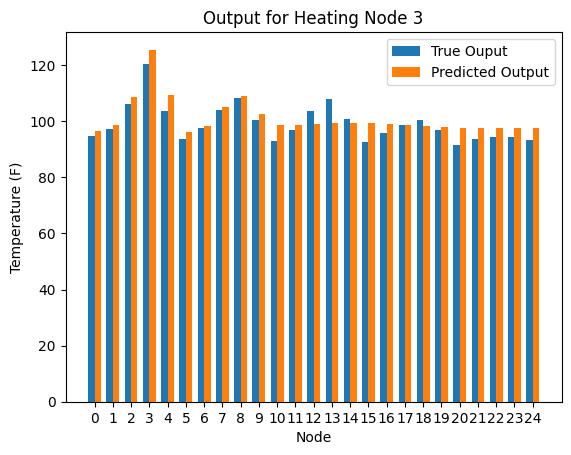

Test Input Shown Below.


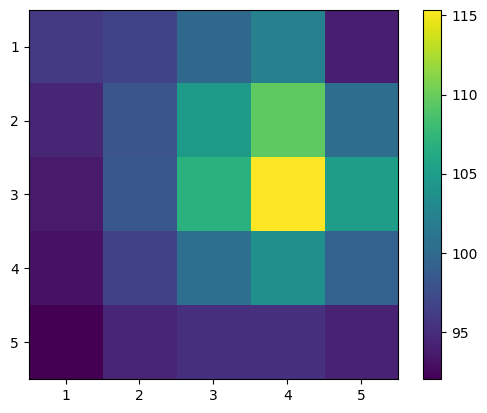

Predicted Ouput Shown Below.


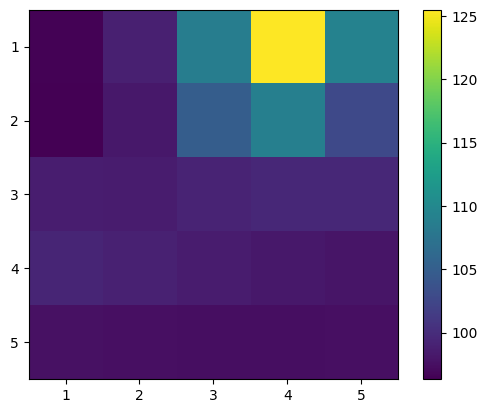

True Ouput Shown Below.


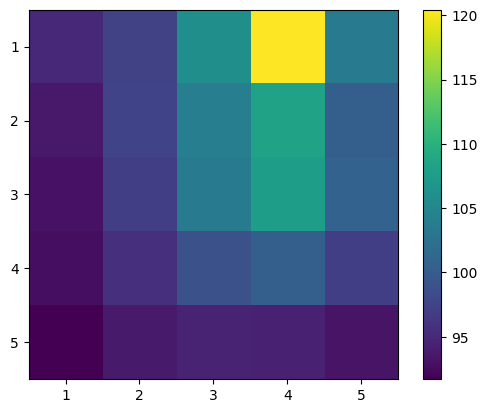

The heated node is 3 and the error is 39.64720879921456


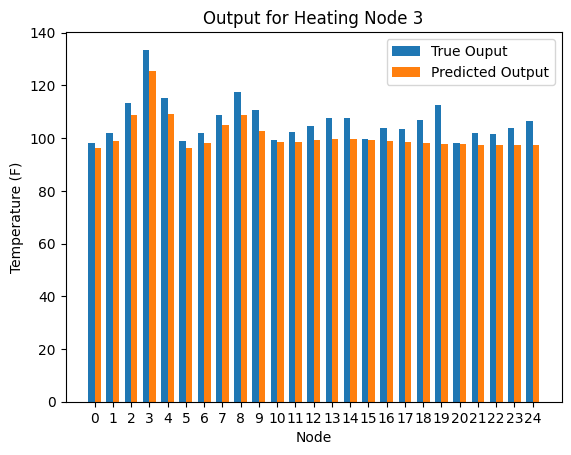

Test Input Shown Below.


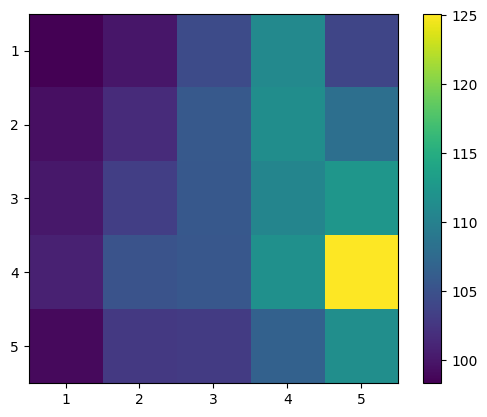

Predicted Ouput Shown Below.


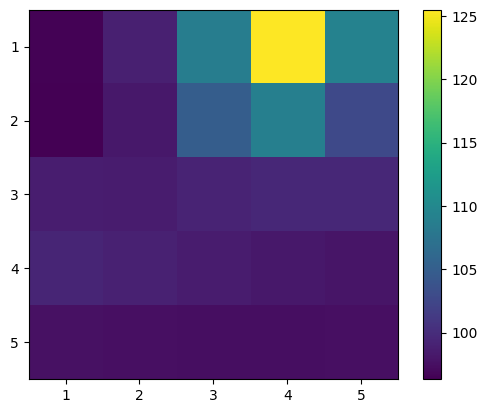

True Ouput Shown Below.


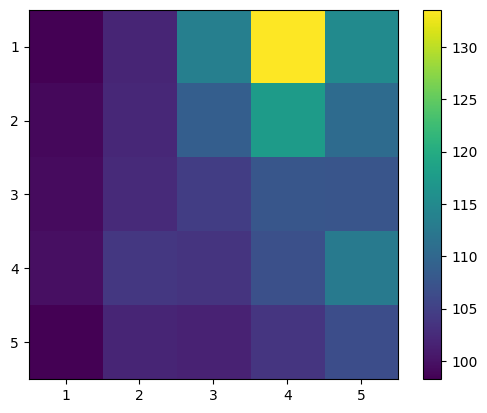

The heated node is 24 and the error is 55.8026097050379


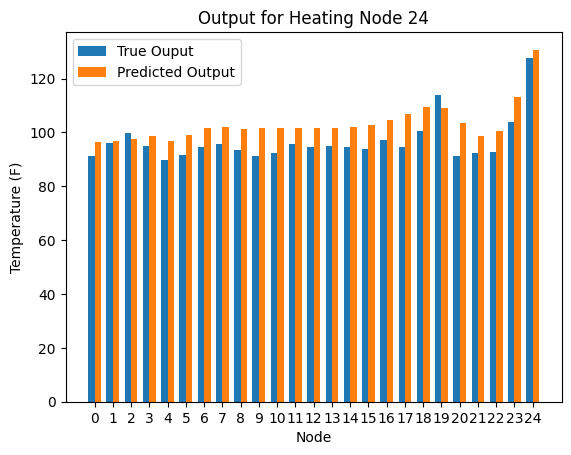

Test Input Shown Below.


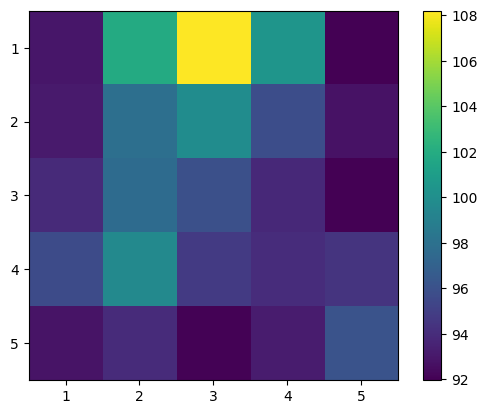

Predicted Ouput Shown Below.


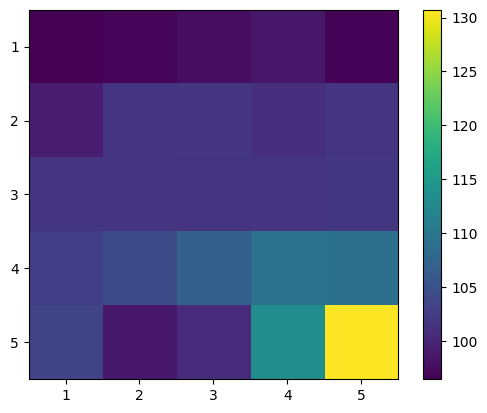

True Ouput Shown Below.


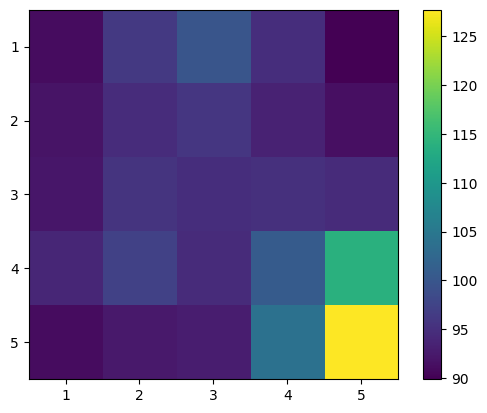

The heated node is 14 and the error is 33.11213753957301


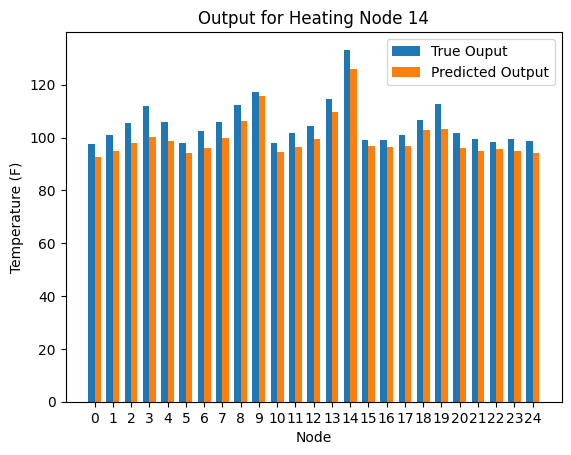

Test Input Shown Below.


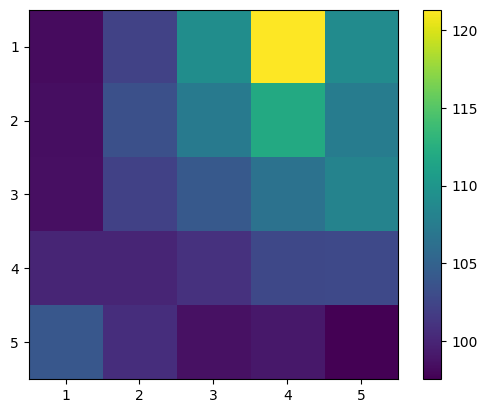

Predicted Ouput Shown Below.


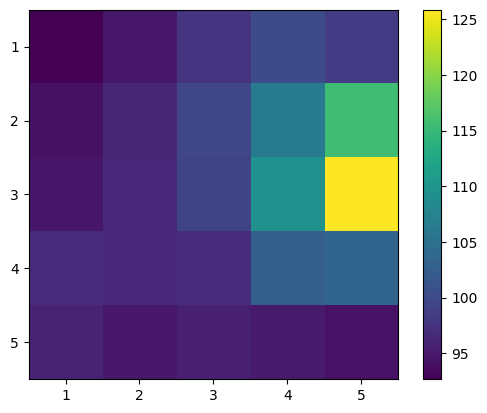

True Ouput Shown Below.


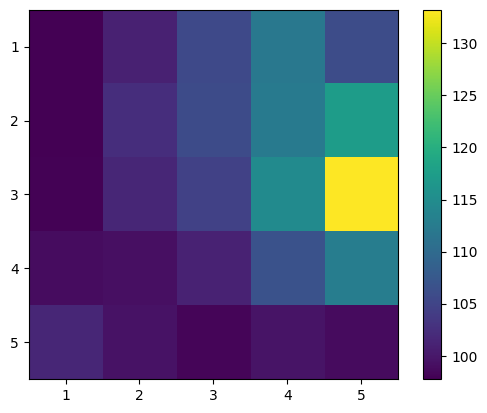

The heated node is 1 and the error is 47.73120628834934


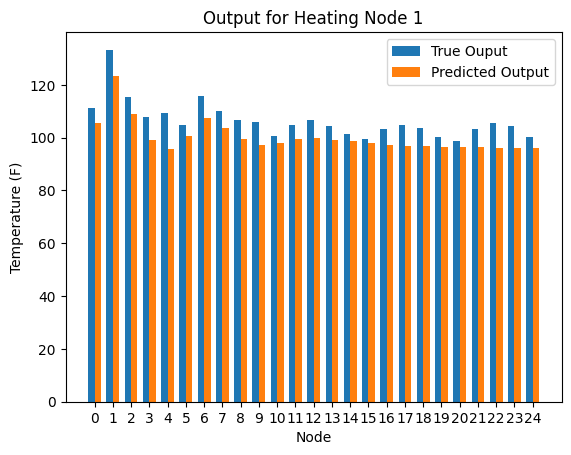

Test Input Shown Below.


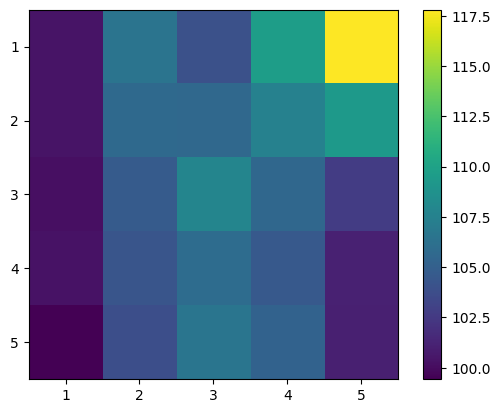

Predicted Ouput Shown Below.


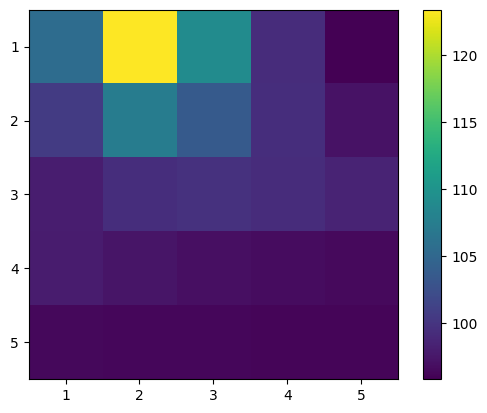

True Ouput Shown Below.


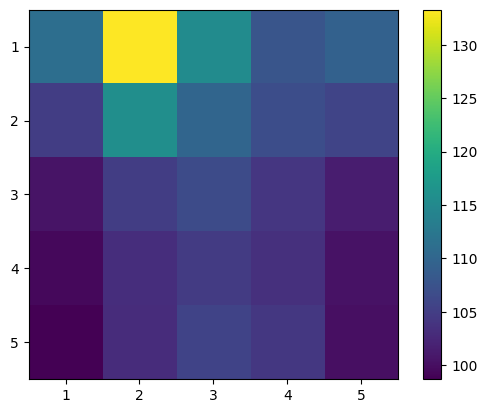

The heated node is 4 and the error is 19.70115443117451


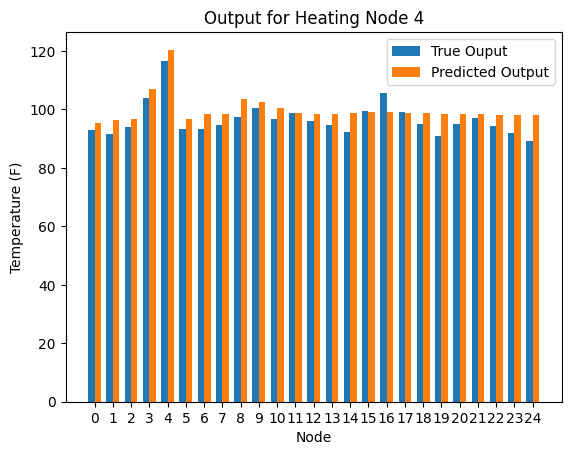

Test Input Shown Below.


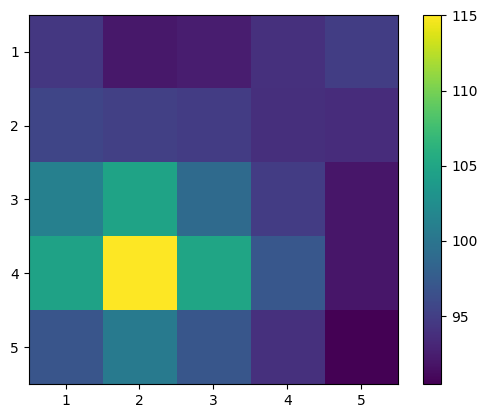

Predicted Ouput Shown Below.


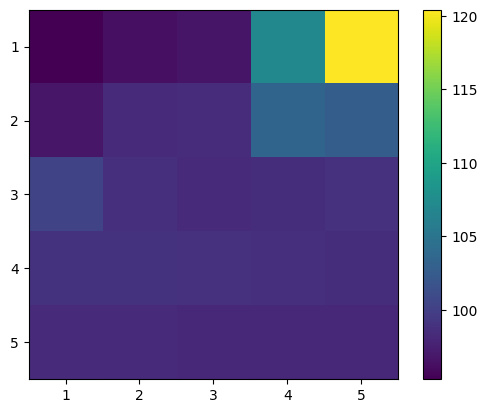

True Ouput Shown Below.


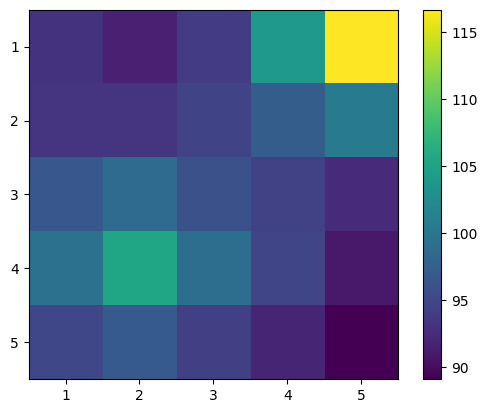

The heated node is 8 and the error is 38.27547692882364


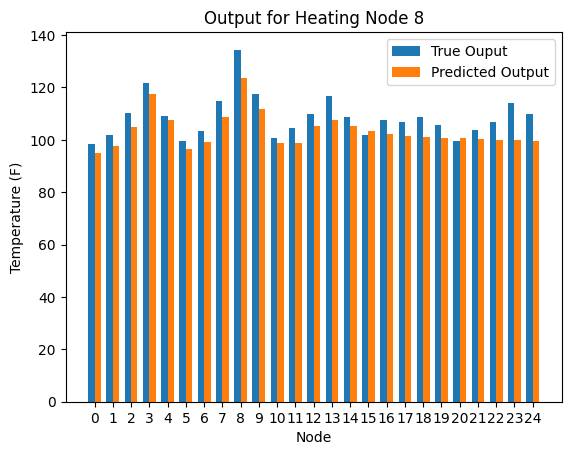

Test Input Shown Below.


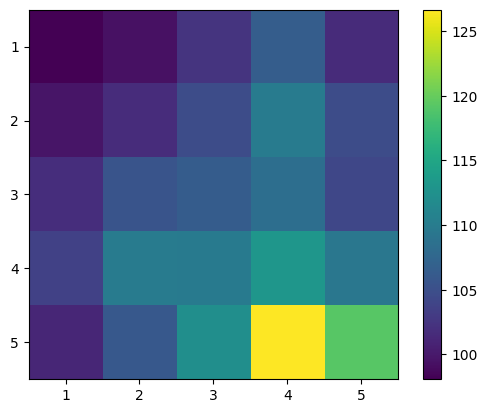

Predicted Ouput Shown Below.


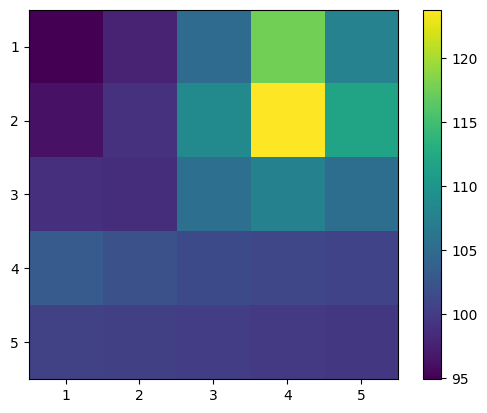

True Ouput Shown Below.


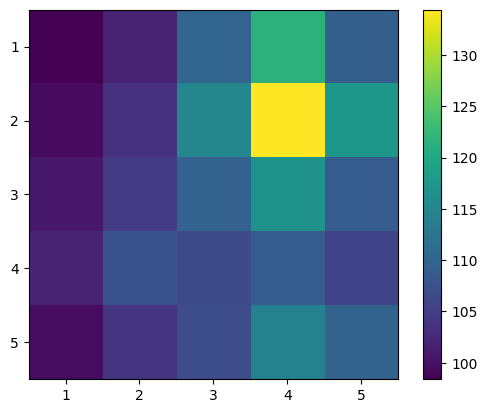

The heated node is 7 and the error is 63.23397402459055


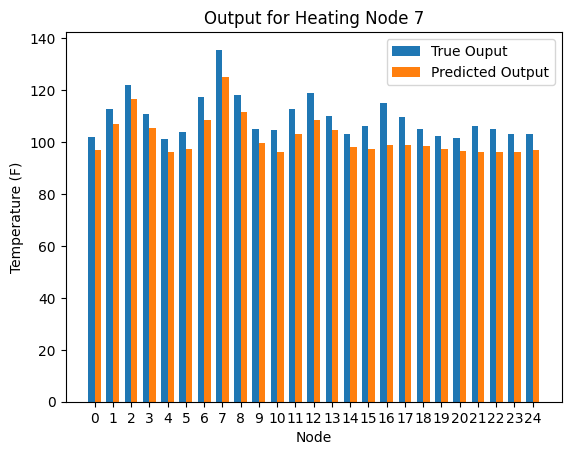

Test Input Shown Below.


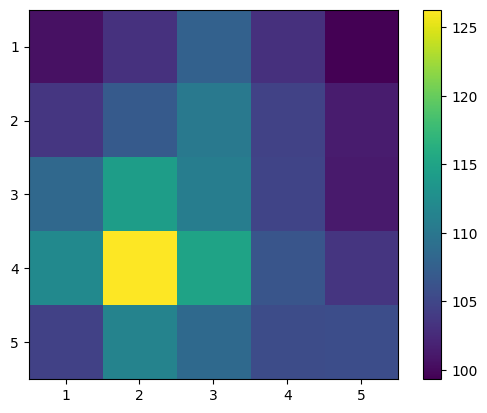

Predicted Ouput Shown Below.


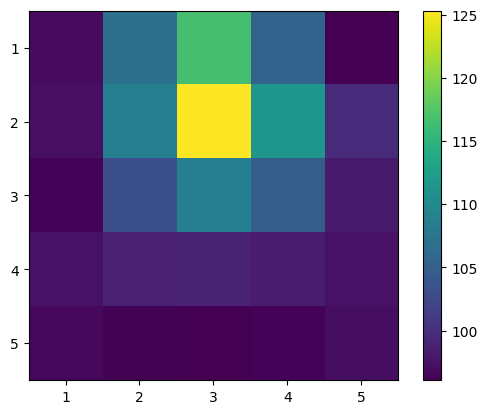

True Ouput Shown Below.


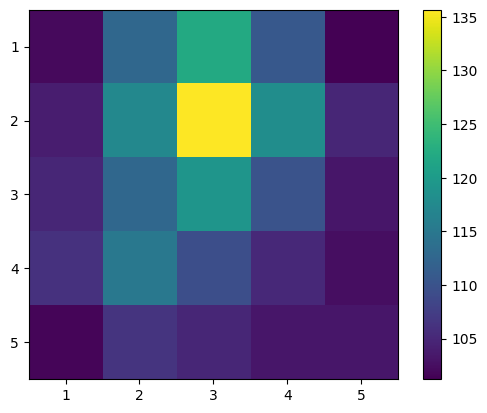

The heated node is 5 and the error is 28.81853167168797


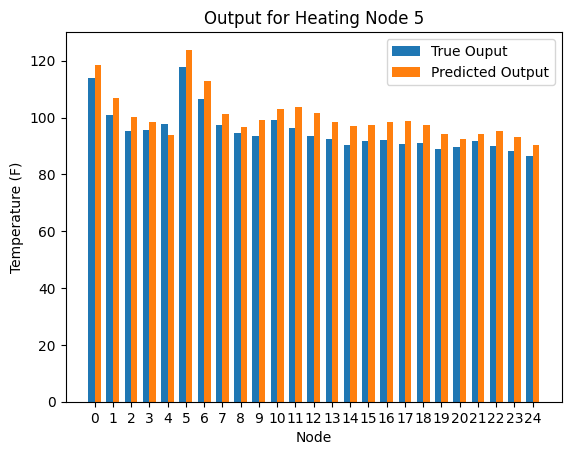

Test Input Shown Below.


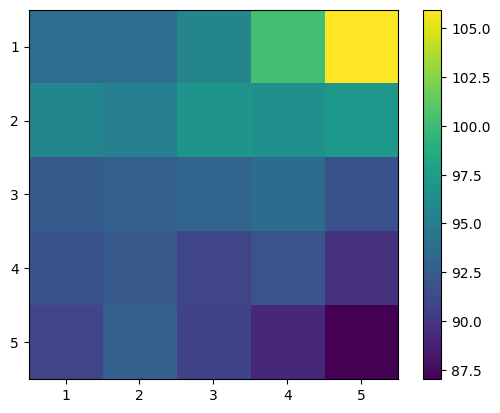

Predicted Ouput Shown Below.


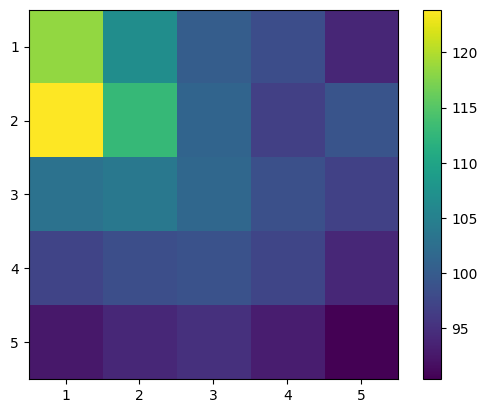

True Ouput Shown Below.


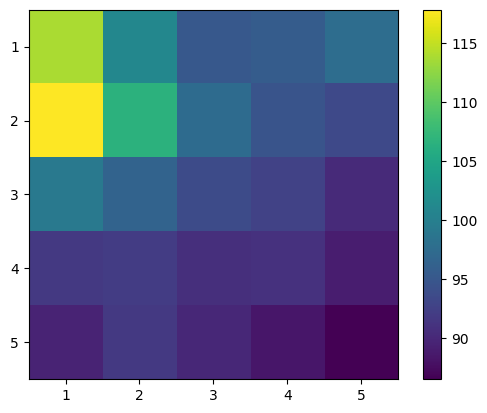

The heated node is 9 and the error is 7.724095806686678


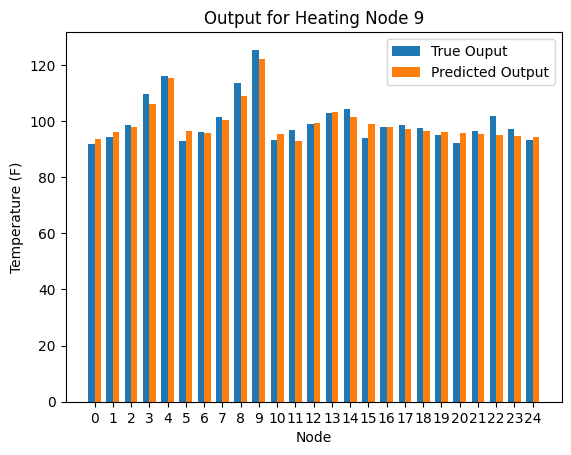

Test Input Shown Below.


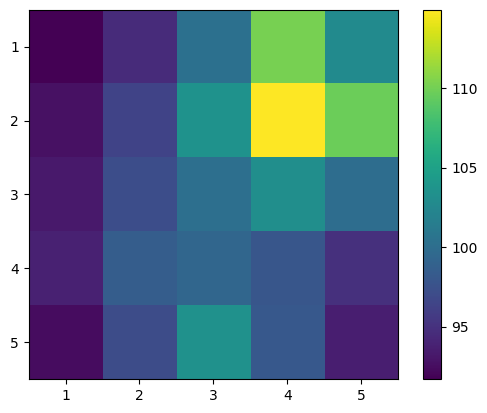

Predicted Ouput Shown Below.


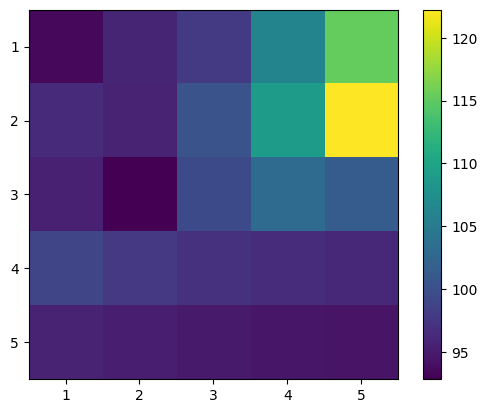

True Ouput Shown Below.


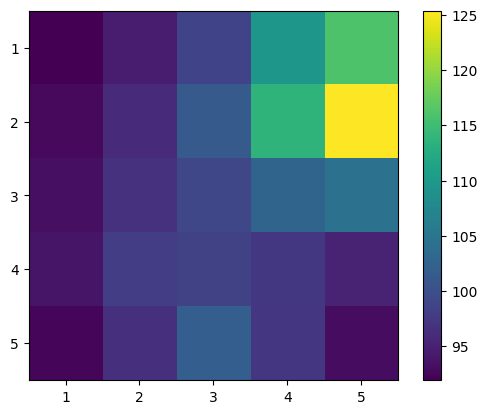

The heated node is 21 and the error is 18.368555769568804


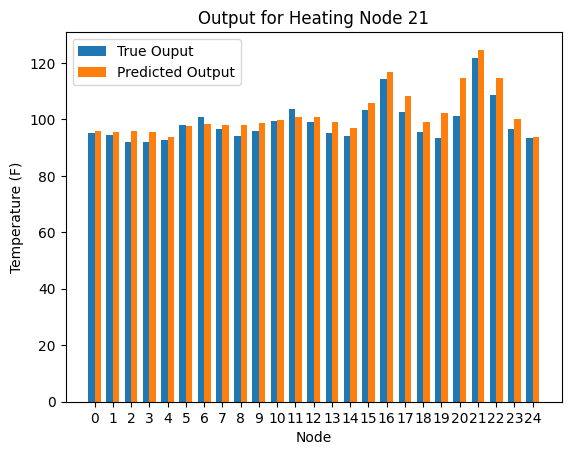

Test Input Shown Below.


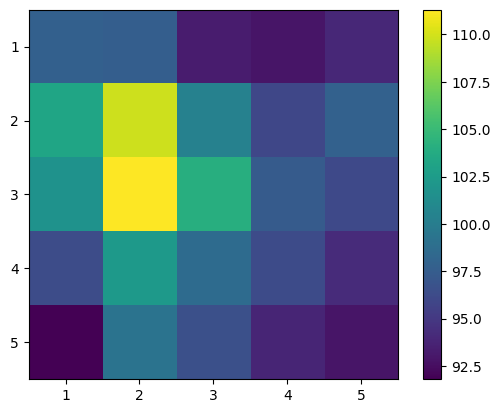

Predicted Ouput Shown Below.


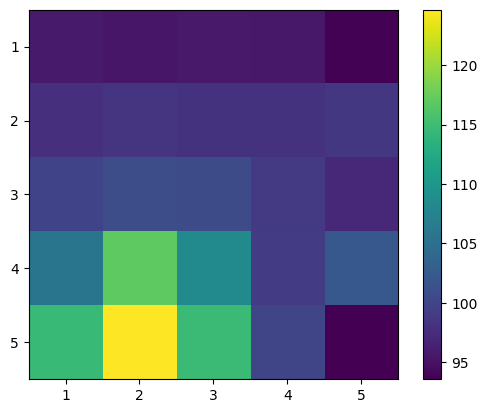

True Ouput Shown Below.


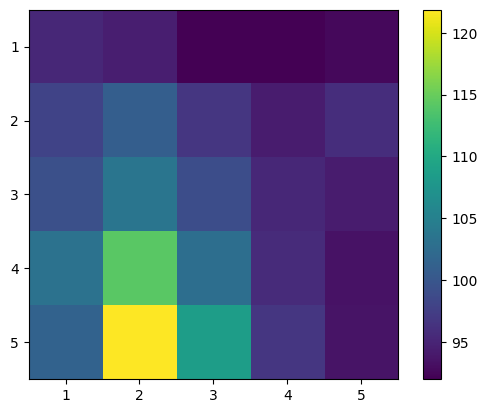

The heated node is 18 and the error is 26.894450244051406


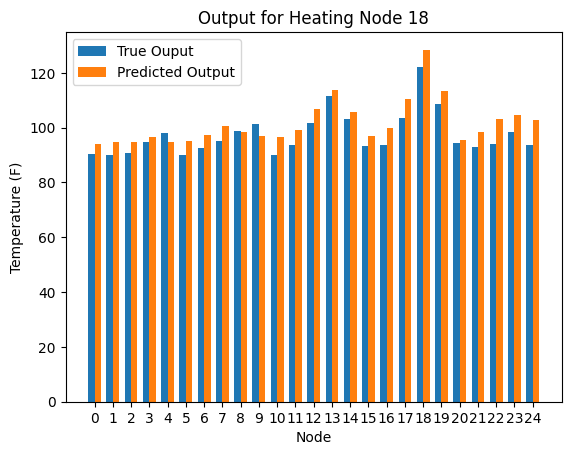

Test Input Shown Below.


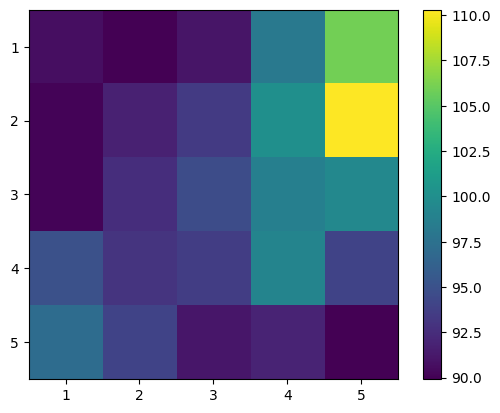

Predicted Ouput Shown Below.


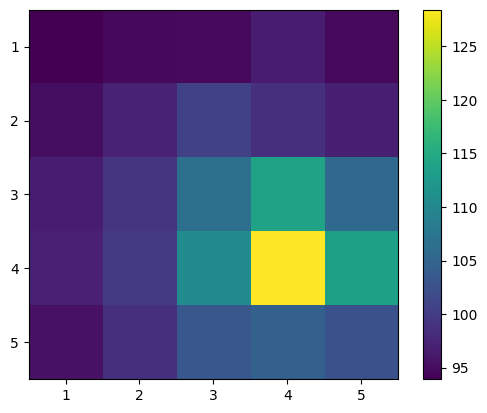

True Ouput Shown Below.


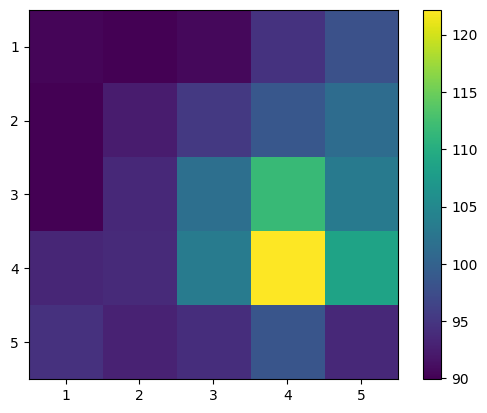

The heated node is 1 and the error is 35.52076177177482


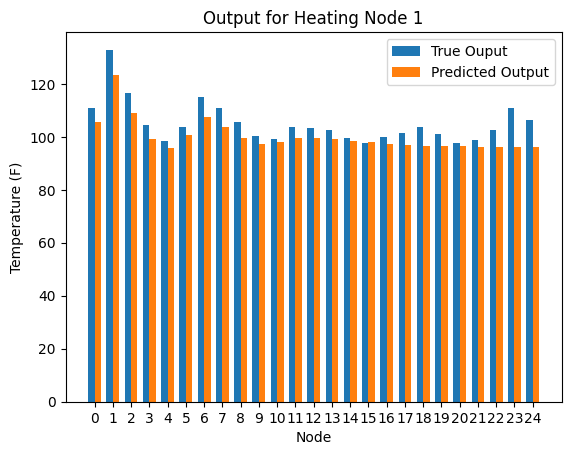

Test Input Shown Below.


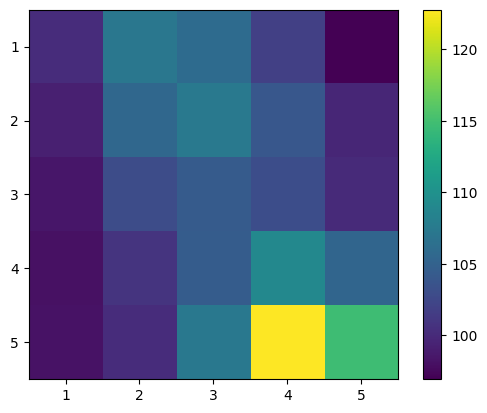

Predicted Ouput Shown Below.


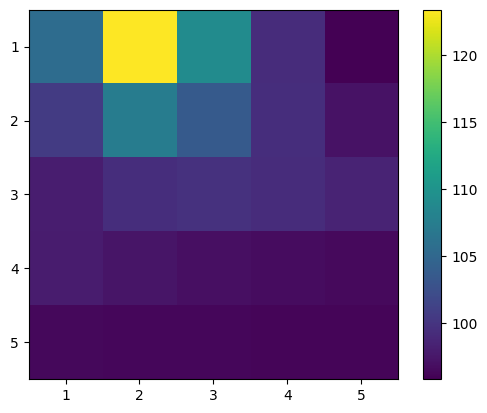

True Ouput Shown Below.


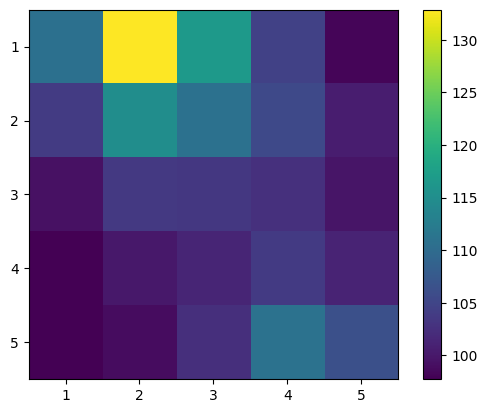

The heated node is 20 and the error is 25.76315121739171


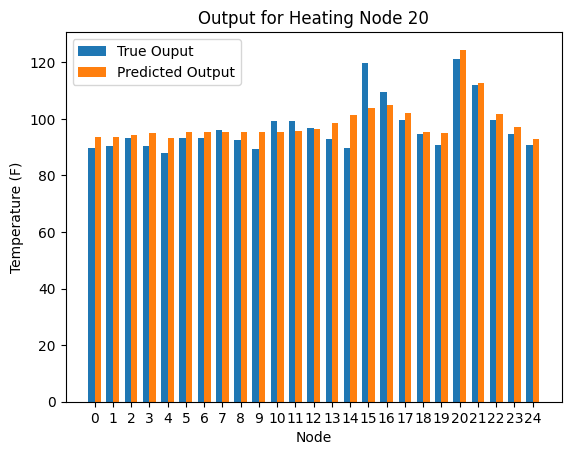

Test Input Shown Below.


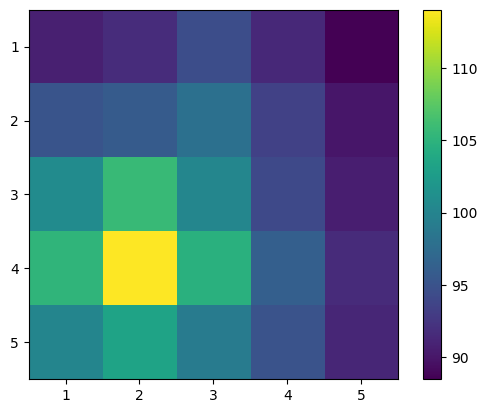

Predicted Ouput Shown Below.


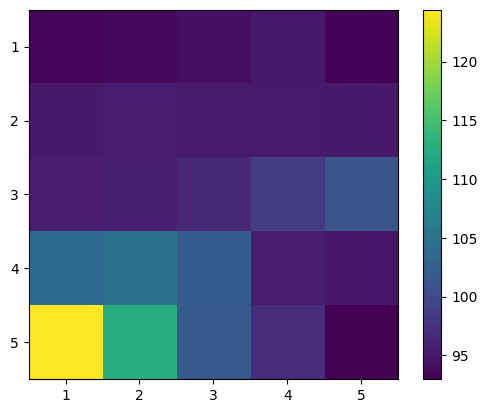

True Ouput Shown Below.


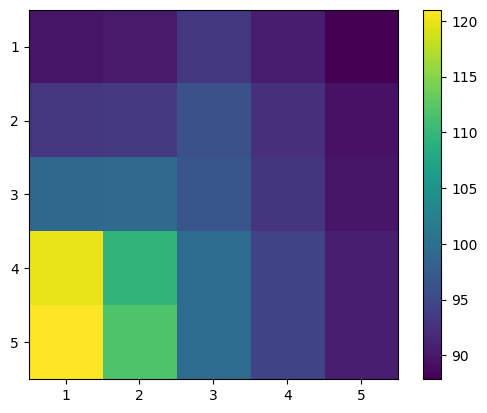

The heated node is 24 and the error is 35.98655876533127


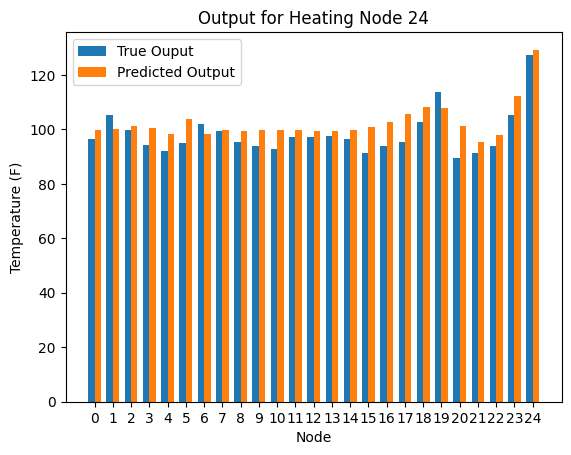

Test Input Shown Below.


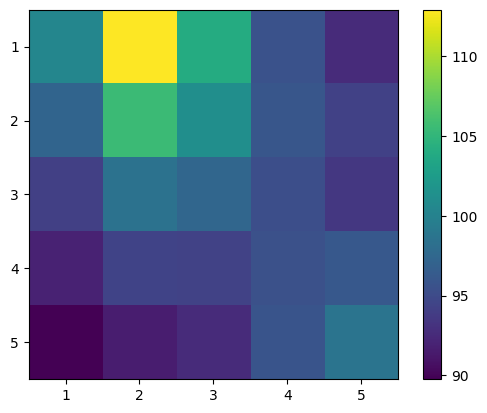

Predicted Ouput Shown Below.


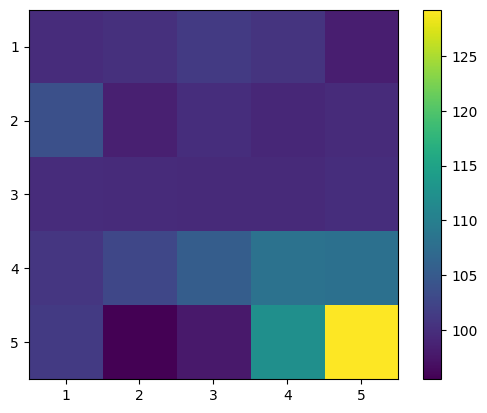

True Ouput Shown Below.


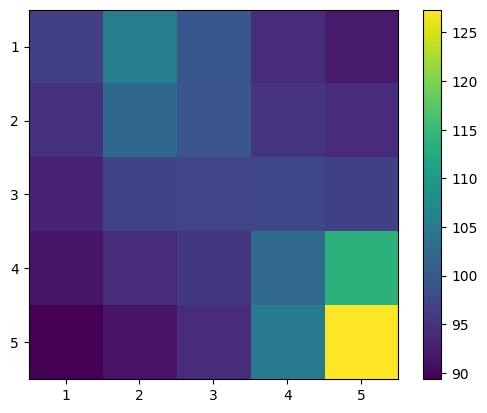

The heated node is 17 and the error is 16.06560535311698


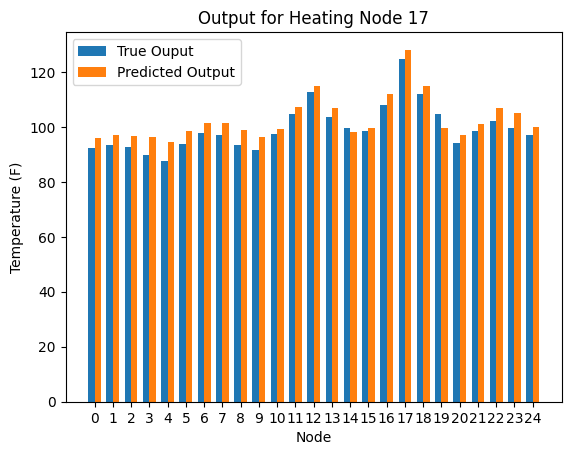

Test Input Shown Below.


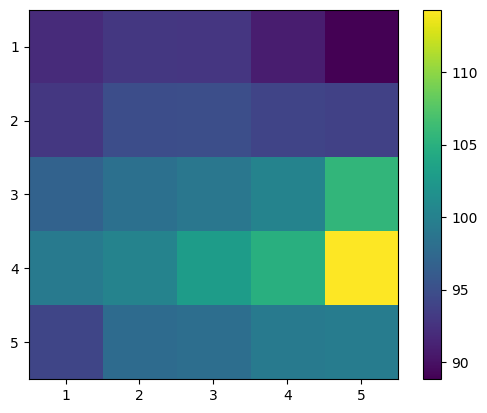

Predicted Ouput Shown Below.


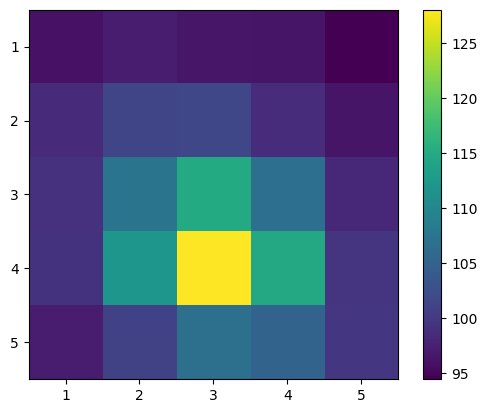

True Ouput Shown Below.


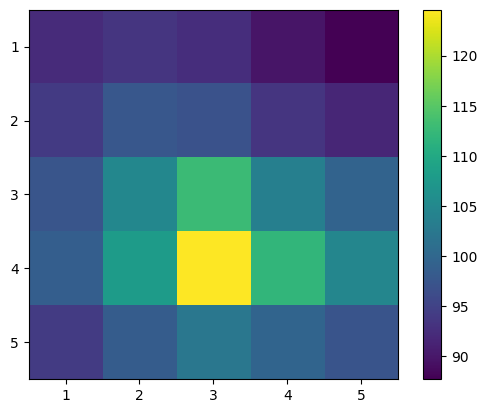

The heated node is 16 and the error is 1.842996136301669


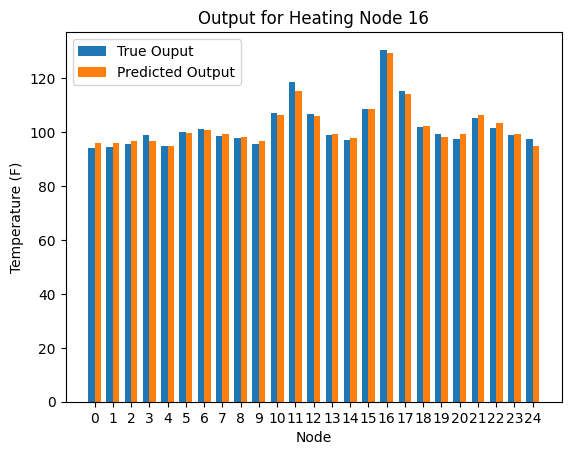

Test Input Shown Below.


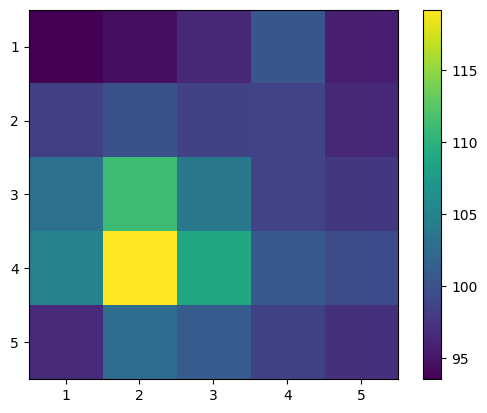

Predicted Ouput Shown Below.


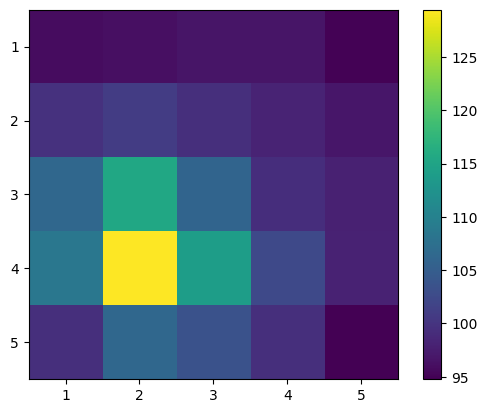

True Ouput Shown Below.


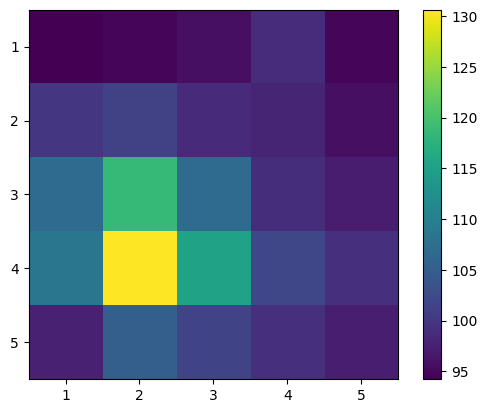

The heated node is 23 and the error is 39.95492044565264


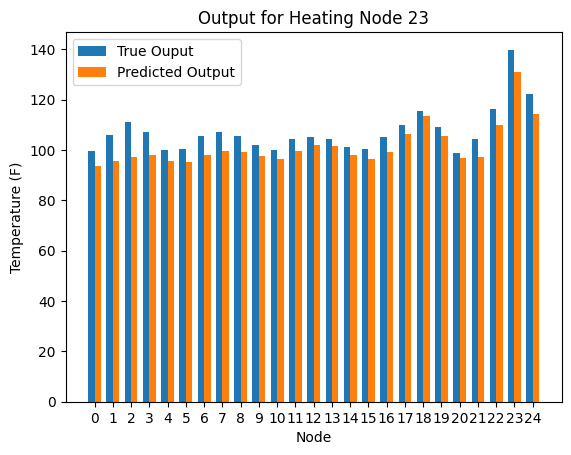

Test Input Shown Below.


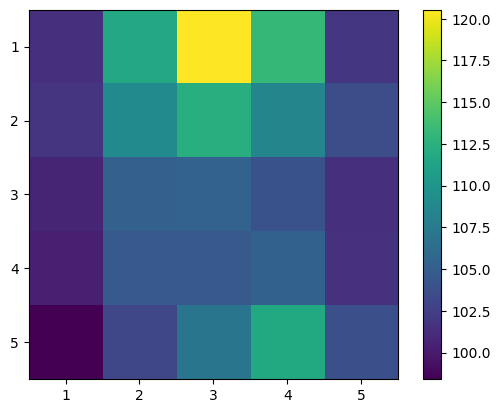

Predicted Ouput Shown Below.


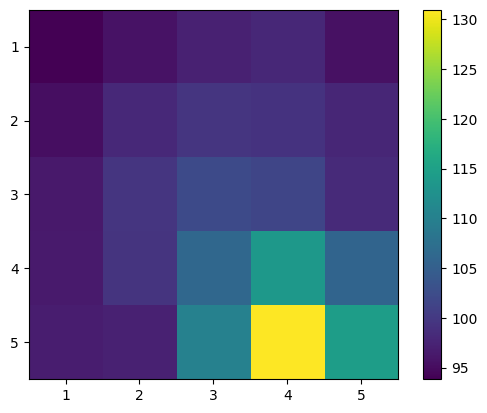

True Ouput Shown Below.


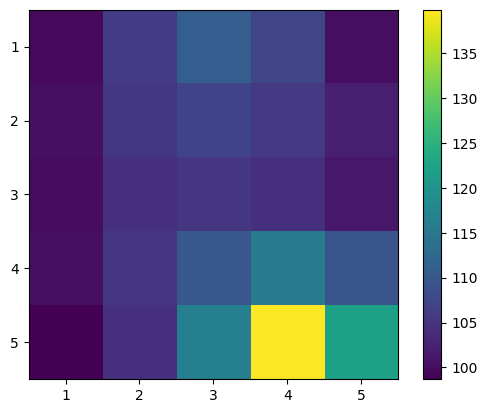

The heated node is 3 and the error is 47.26556523920967


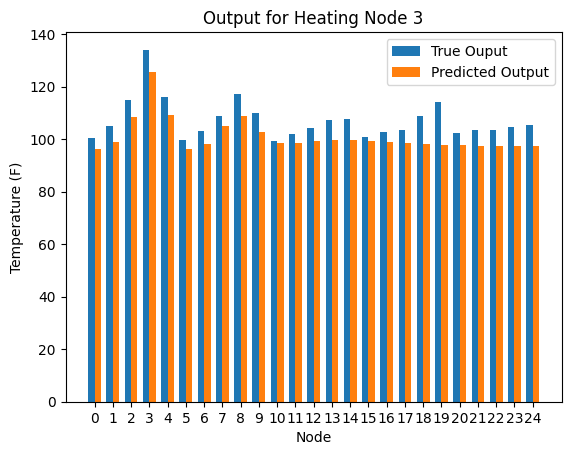

Test Input Shown Below.


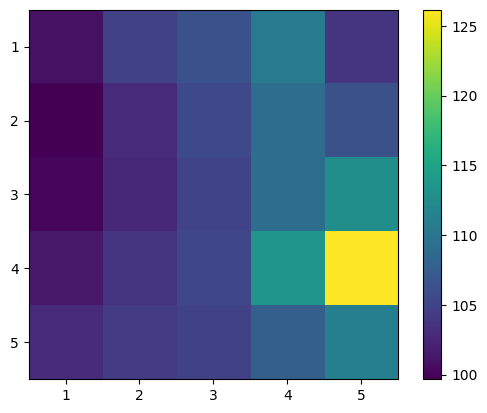

Predicted Ouput Shown Below.


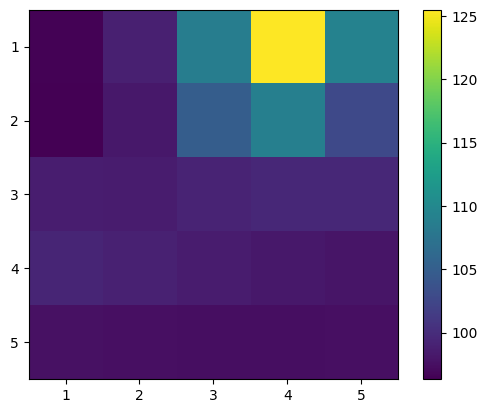

True Ouput Shown Below.


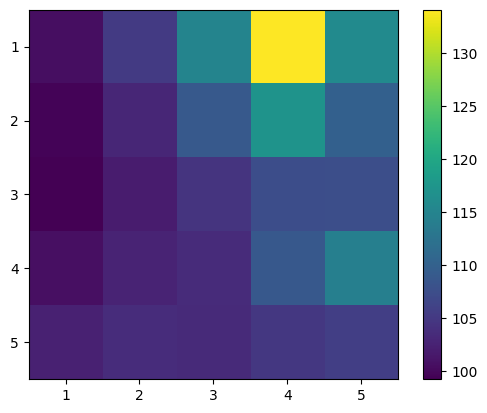

The heated node is 4 and the error is 19.217675835732372


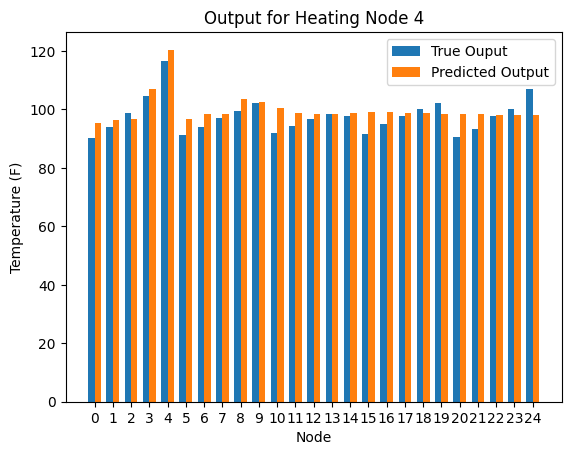

Test Input Shown Below.


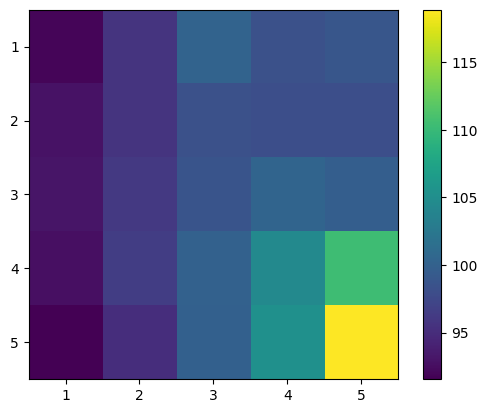

Predicted Ouput Shown Below.


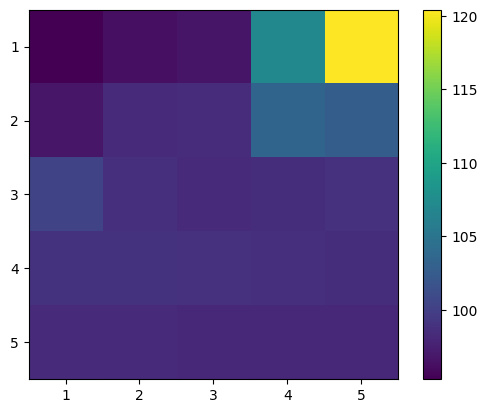

True Ouput Shown Below.


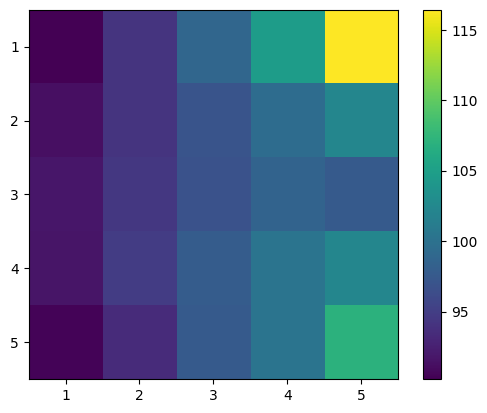

The average MSE error for all 25 temperatures in the grid is: 52.43122718727276
The average % error for any temperature square is: 4.6650942994833935


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

error_total = np.zeros(25)
error_percent_list = np.zeros(25)
case_total = np.zeros(25)

for n in range(np.shape(Test_Initial_Temp_Arrays)[0]):
  test_case = n
  # Create an example temperature input (homogeous temp)
  temp_input = Test_Initial_Temp_Arrays[test_case]
  test_initial_temp_torch = torch.tensor(temp_input,dtype=torch.float32)
  test_initial_temp_reshape = torch.reshape(test_initial_temp_torch, (1, 25))
  test_initial_temp_reshape = test_initial_temp_reshape.to(device)
  #print(temp_input)

  # Create a linspace of nodes to evalute at
  example_trunk_input = torch.linspace(0, 24, steps=25)
  example_trunk_input = example_trunk_input.to(device)
  #print(example_trunk_input)

  # Find which node is heated/which model to use
  heated_node_position = Test_Position_Arrays[test_case]
  test_position_one = heated_node_position[0]+(heated_node_position[1]-1)*5 - 1
  #print(test_position_one)


  val_pred_output_list = [] # Initialize an array to hold the 25 outputs for each trunk input
  with torch.no_grad():
    # Input all of the trunk inputs to each model
    for p in range(25):
      # Branch and Trunk Prediction
      val_branch_pred = branch_net_dict[test_position_one](test_initial_temp_reshape)
      trunk_in_val = torch.reshape(example_trunk_input[p],(-1,1))
      val_trunk_pred = trunk_net_dict[test_position_one](trunk_in_val)

      # Dot Product and append to the list for a full array output
      val_pred_output = torch.sum(val_trunk_pred*val_branch_pred, dim = -1)
      val_pred_output = val_pred_output.to('cpu').numpy()
      val_pred_output_list.append(val_pred_output)

  #The mean squared error
  error = loss_function(torch.tensor(val_pred_output_list).reshape((25,)),torch.tensor(Test_Final_Temp_Arrays[test_case].flatten()).reshape((25,)))
  # The total error of all 25 squares
  #print("The total error is: ")
  #print(torch.abs((torch.tensor(val_pred_output_list).reshape((25,)))-(torch.tensor(Test_Final_Temp_Arrays[test_case].flatten()).reshape((25,)))))
  error_percent = torch.sum(torch.abs((torch.tensor(val_pred_output_list).reshape((25,))-(torch.tensor(Test_Final_Temp_Arrays[test_case].flatten()).reshape((25,)))))/(torch.tensor(Test_Final_Temp_Arrays[test_case].flatten()).reshape((25,)))*100)
  #error = torch.sum((torch.tensor(val_pred_output_list).reshape((25,)))-(torch.tensor(Test_Final_Temp_Arrays[test_case].flatten()).reshape((25,))))
  #print(error)

  error_percent_list[test_position_one] = error_percent_list[test_position_one] + error_percent
  error_total[test_position_one] = error_total[test_position_one] + error.item()
  case_total[test_position_one] = case_total[test_position_one] + 1

  if n % 25 == 0:
    print("The heated node is " + str(test_position_one)+ ' and the error is '+str(error.item()))

    bar_width = 0.35
    bar_positions_1 = np.arange(25)
    bar_positions_2 = bar_positions_1 + bar_width
    plt.bar(example_trunk_input.to('cpu').numpy(),Test_Final_Temp_Arrays[test_case].flatten(),width=bar_width,label='True Ouput')
    plt.bar(example_trunk_input.to('cpu').numpy()+bar_width,np.reshape(val_pred_output_list,-1),width=bar_width,label='Predicted Output')
    plt.legend()
    plt.xticks(bar_positions_1 + bar_width / 2, bar_positions_1)  # Set x-axis ticks at the center of each group

    plt.xlabel('Node')
    plt.ylabel('Temperature (F)')
    plt.title('Output for Heating Node ' + str(test_position_one))
    plt.show()

    # Plot the 5x5 Input
    print('Test Input Shown Below.')
    cmap = plt.cm.viridis
    plt.imshow(temp_input, cmap=cmap,extent=[1, 6, 6, 1])
    plt.xticks(np.arange(5) + 1.5, np.arange(1, 6))
    plt.yticks(np.arange(5) + 1.5, np.arange(1, 6))
    plt.colorbar()
    plt.show()

    # Plot the 5x5 Output
    print('Predicted Ouput Shown Below.')
    pred_out_5x5 = np.reshape(val_pred_output_list,(5,5))
    cmap = plt.cm.viridis
    plt.imshow(pred_out_5x5, cmap=cmap, extent=[1, 6, 6, 1])
    plt.xticks(np.arange(5) + 1.5, np.arange(1, 6))
    plt.yticks(np.arange(5) + 1.5, np.arange(1, 6))
    plt.colorbar()
    plt.show()

    # Plot the 5x5 Output
    print('True Ouput Shown Below.')
    pred_out_5x5 = np.reshape(Test_Final_Temp_Arrays[test_case],(5,5))
    cmap = plt.cm.viridis
    plt.imshow(pred_out_5x5, cmap=cmap,extent=[1, 6, 6, 1])
    plt.xticks(np.arange(5) + 1.5, np.arange(1, 6))
    plt.yticks(np.arange(5) + 1.5, np.arange(1, 6))
    plt.colorbar()
    plt.show()
    np.set_printoptions(precision=2,suppress=True)
    #print(torch.abs((torch.tensor(val_pred_output_list).reshape((25,)))-(torch.tensor(Test_Final_Temp_Arrays[test_case].flatten()).reshape((25,)))).numpy())


print("The average MSE error for all 25 temperatures in the grid is: " + str(np.mean(error_total/case_total)))
print("The average % error for any temperature square is: " + str(sum(error_percent_list)/500/25))
